## MT3DMS Problem 10 Two Domains

The purpose of this example is to demonstrate the model setup for
a coupled GWF-GWT simulation with submodels. It replicates the
three-dimensional field case study model from the 1999 MT3DMS report.
The results are checked for equivalence with the MODFLOW 6 GWT
solutions as produced by the example 'MT3DMS problem 10'.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import git
import matplotlib.pyplot as plt
import numpy as np
import pooch
from flopy.plot.styles import styles
from flopy.utils.util_array import read1d
from modflow_devtools.misc import get_env

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwt-gwtgwt-p10"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
data_path = root / "data" / sim_name if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings. Note: the (relative) dimensions of the two models are not configurable.

In [2]:
# Model units
length_units = "feet"
time_units = "days"

# Model parameters
nlay = 4  # Number of layers
nlay_inn = 4  # Number of layers
nrow = 61  # Number of rows
nrow_inn = 45  # Number of rows inner model
ncol = 40  # Number of columns
ncol_inn = 28  # Number of columns inner model
delr = "varies"  # Column width ($ft$)
delr_inn = 50  # Column width inner model ($ft$)
delc = "varies"  # Row width ($ft$)
delc_inn = 50  # Row width inner model ($ft$)
xshift = 5100.0  # X offset inner model
yshift = 9100.0  # Y offset inner model
delz = 25.0  # Layer thickness ($ft$)
top = 780.0  # Top of the model ($ft$)
satthk = 100.0  # Saturated thickness ($ft$)
k1 = 60.0  # Horiz. hyd. conductivity of layers 1 and 2 ($ft/day$)
k2 = 520.0  # Horiz. hyd. conductivity of layers 3 and 4 ($ft/day$)
vka = 0.1  # Ratio of vertical to horizontal hydraulic conductivity
rech = 5.0  # Recharge rate ($in/yr$)
crech = 0.0  # Concentration of recharge ($ppm$)
prsity = 0.3  # Porosity
al = 10.0  # Longitudinal dispersivity ($ft$)
trpt = 0.2  # Ratio of horizontal transverse dispersivity to longitudinal dispersivity
trpv = 0.2  # Ratio of vertical transverse dispersivity to longitudinal dispersivity
rhob = 1.7  # Aquifer bulk density ($g/cm^3$)
sp1 = 0.176  # Distribution coefficient ($cm^3/g$)

# Time discretization parameters
perlen = 1000.0  # Simulation time ($days$)
nstp = 500  # Number of time steps
ttsmult = 1.0  # multiplier

# Additional model input
delr = [2000, 1600, 800, 400, 200, 100] + 28 * [50] + [100, 200, 400, 800, 1600, 2000]
delc = (
    [2000, 2000, 2000, 1600, 800, 400, 200, 100]
    + 45 * [50]
    + [100, 200, 400, 800, 1600, 2000, 2000, 2000]
)

hk = [k1, k1, k2, k2]
laytyp = icelltype = 0

# Starting heads from file:
gwt_mt3dms_sim_name = "ex-gwt-mt3dms-p10"
gwt_mt3dms_data_path = data_path.parent / gwt_mt3dms_sim_name if root else pl.Path.cwd()
fname = "p10shead.dat"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{gwt_mt3dms_sim_name}/{fname}",
    fname=fname,
    path=gwt_mt3dms_data_path,
    known_hash="md5:c6591c3c3cfd023ab930b7b1121bfccf",
)
with open(fpath) as f:
    s0 = np.empty((nrow * ncol), dtype=float)
    s0 = read1d(f, s0).reshape((nrow, ncol))
strt = np.zeros((nlay, nrow, ncol), dtype=float)
for k in range(nlay):
    strt[k] = s0
strt_inn = strt[:, 8:53, 6:34]

# Active model domain
idomain = np.ones((nlay, nrow, ncol), dtype=int)
idomain[:, 8:53, 6:34] = 0
idomain_inn = 1
icbund = idomain

# Boundary conditions
rech = 12.7 / 365 / 30.48  # cm/yr -> ft/day
crch = 0.0

# MF6 pumping information for inner DIS
welspd_mf6 = []
#                 [(layer, row, column),     flow, conc]
welspd_mf6.append([(3 - 1, 3 - 1, 23 - 1), -19230.0, 0.00])
welspd_mf6.append([(3 - 1, 11 - 1, 20 - 1), -19230.0, 0.00])
welspd_mf6.append([(3 - 1, 18 - 1, 17 - 1), -19230.0, 0.00])
welspd_mf6.append([(3 - 1, 25 - 1, 14 - 1), -19230.0, 0.00])
welspd_mf6.append([(3 - 1, 32 - 1, 11 - 1), -19230.0, 0.00])
welspd_mf6.append([(3 - 1, 40 - 1, 8 - 1), -19230.0, 0.00])
welspd_mf6.append([(3 - 1, 40 - 1, 3 - 1), -15384.0, 0.00])
welspd_mf6.append([(3 - 1, 44 - 1, 11 - 1), -17307.0, 0.00])
wel_mf6_spd = {0: welspd_mf6}

# Transport related
# Starting concentrations from file:
fname = "p10cinit.dat"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{gwt_mt3dms_sim_name}/{fname}",
    fname=fname,
    path=gwt_mt3dms_data_path,
    known_hash="md5:8e2d3ba7af1ec65bb07f6039d1dfb2c8",
)
with open(fpath) as f:
    c0 = np.empty((nrow * ncol), dtype=float)
    c0 = read1d(f, c0).reshape((nrow, ncol))
sconc = np.zeros((nlay, nrow, ncol), dtype=float)
sconc[1] = 0.2 * c0
sconc[2] = c0

# starting concentration for inner model
sconc_inn = sconc[:, 8:53, 6:34]

# Dispersion
ath1 = al * trpt
atv = al * trpv
dmcoef = 0.0  # ft^2/day

c0 = 0.0
botm = [top - delz * k for k in range(1, nlay + 1)]
mixelm = 0

# Reactive transport related terms
isothm = 1  # sorption type; 1=linear isotherm (equilibrium controlled)
sp2 = 0.0  # w/ isothm = 1 this is read but not used
# ***Note:  In the original documentation for this problem, the following two
#           values are specified in units of g/cm^3 and cm^3/g, respectively.
#           All other units in this problem appear to use ft, including the
#           grid discretization, aquifer K (ft/day), recharge (ft/yr),
#           pumping (ft^3/day), & dispersion (ft).  Because this problem
#           attempts to recreate the original problem for comparison purposes,
#           we are sticking with these values while also acknowledging this
#           discrepancy.
rhob = 1.7  # g/cm^3
sp1 = 0.176  # cm^3/g  (Kd: "Distribution coefficient")

# Transport observations
# Instantiate the basic transport package for the inner model
obs = [
    [3 - 1, 3 - 1, 23 - 1],
    [3 - 1, 11 - 1, 20 - 1],
    [3 - 1, 18 - 1, 17 - 1],
    [3 - 1, 25 - 1, 14 - 1],
    [3 - 1, 32 - 1, 11 - 1],
    [3 - 1, 40 - 1, 8 - 1],
    [3 - 1, 40 - 1, 3 - 1],
    [3 - 1, 44 - 1, 11 - 1],
]

# Solver settings
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-6, 1e-6, 1.0
hclose_gwt, rclose_gwt = 1e-6, 1e-6
percel = 1.0  # HMOC parameters
itrack = 2
wd = 0.5
dceps = 1.0e-5
nplane = 0
npl = 0
nph = 16
npmin = 2
npmax = 32
dchmoc = 1.0e-3
nlsink = nplane
npsink = nph
nadvfd = 1

# Model names
gwfname_out = "gwf-outer"
gwfname_inn = "gwf-inner"
gwtname_out = "gwt-outer"
gwtname_inn = "gwt-inner"

# Exchange data for GWF-GWF and GWT-GWT
exgdata = None

# Advection
scheme = "Undefined"

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models():
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")

    # Instantiating time discretization
    tdis_rc = [(perlen, nstp, 1.0)]
    flopy.mf6.ModflowTdis(sim, nper=1, perioddata=tdis_rc, time_units=time_units)

    # add both solutions to the simulation
    add_flow(sim)
    add_transport(sim)

    # add flow-transport coupling
    flopy.mf6.ModflowGwfgwt(
        sim,
        exgtype="GWF6-GWT6",
        exgmnamea=gwfname_out,
        exgmnameb=gwtname_out,
        filename="{}.gwfgwt".format("outer"),
    )
    flopy.mf6.ModflowGwfgwt(
        sim,
        exgtype="GWF6-GWT6",
        exgmnamea=gwfname_inn,
        exgmnameb=gwtname_inn,
        filename="{}.gwfgwt".format("inner"),
    )

    return sim


def add_flow(sim):
    global exgdata

    # Instantiating solver for flow model
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="CG",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename="{}.ims".format("gwfsolver"),
    )

    gwf_outer = add_outer_gwfmodel(sim)
    gwf_inner = add_inner_gwfmodel(sim)

    sim.register_ims_package(imsgwf, [gwf_outer.name, gwf_inner.name])

    # LGR
    exgdata = []
    # east
    for ilay in range(nlay):
        for irow in range(nrow_inn):
            irow_outer = irow + 8
            exgdata.append(
                (
                    (ilay, irow_outer, 5),
                    (ilay, irow, 0),
                    1,
                    50.0,
                    25.0,
                    50.0,
                    0.0,
                    75.0,
                )
            )
    # west
    for ilay in range(nlay):
        for irow in range(nrow_inn):
            irow_outer = irow + 8
            exgdata.append(
                (
                    (ilay, irow_outer, ncol - 6),
                    (ilay, irow, ncol_inn - 1),
                    1,
                    50.0,
                    25.0,
                    50.0,
                    180.0,
                    75.0,
                )
            )
    # north
    for ilay in range(nlay):
        for icol in range(ncol_inn):
            icol_outer = icol + 6
            exgdata.append(
                (
                    (ilay, 7, icol_outer),
                    (ilay, 0, icol),
                    1,
                    50.0,
                    25.0,
                    50.0,
                    270.0,
                    75.0,
                )
            )
    # south
    for ilay in range(nlay):
        for icol in range(ncol_inn):
            icol_outer = icol + 6
            exgdata.append(
                (
                    (ilay, nrow - 8, icol_outer),
                    (ilay, nrow_inn - 1, icol),
                    1,
                    50.0,
                    25.0,
                    50.0,
                    90.0,
                    75.0,
                )
            )

    gwfgwf = flopy.mf6.ModflowGwfgwf(
        sim,
        exgtype="GWF6-GWF6",
        nexg=len(exgdata),
        exgmnamea=gwf_outer.name,
        exgmnameb=gwf_inner.name,
        exchangedata=exgdata,
        xt3d=False,
        print_flows=True,
        auxiliary=["ANGLDEGX", "CDIST"],
        # dev_interfacemodel_on=True,
    )

    # Observe flow for exchange 439
    gwfgwfobs = {}
    gwfgwfobs["gwfgwf.output.obs.csv"] = [
        ["exchange439", "FLOW-JA-FACE", (439 - 1,)],
    ]
    fname = "gwfgwf.input.obs"
    # cdl -- turn off for now as it causes a flopy load fail
    # gwfgwf.obs.initialize(
    #    filename=fname, digits=25, print_input=True, continuous=gwfgwfobs
    # )


def add_outer_gwfmodel(sim):
    """Create the outer GWF model"""
    mname = gwfname_out

    # Instantiating groundwater flow model
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=mname,
        save_flows=True,
        model_nam_file=f"{mname}.nam",
    )

    # Instantiating discretization package
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
        filename=f"{mname}.dis",
    )

    # Instantiating initial conditions package for flow model
    flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{mname}.ic")

    # Instantiating node-property flow package
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=False,
        k33overk=True,
        icelltype=laytyp,
        k=hk,
        k33=vka,
        save_specific_discharge=True,
        filename=f"{mname}.npf",
    )

    # Instantiate storage package
    flopy.mf6.ModflowGwfsto(gwf, ss=0, sy=0, filename=f"{mname}.sto")

    # Instantiating constant head package
    # MF6 constant head boundaries:
    chdspd = []
    # Loop through the left & right sides for all layers.
    # These boundaries are imposed on the outer model.
    for k in np.arange(nlay):
        for i in np.arange(nrow):
            #              (l, r, c),    head,      conc
            chdspd.append([(k, i, 0), strt[k, i, 0], 0.0])  # left
            chdspd.append([(k, i, ncol - 1), strt[k, i, ncol - 1], 0.0])  # right

        for j in np.arange(1, ncol - 1):  # skip corners, already added above
            #              (l, r, c),   head,        conc
            chdspd.append([(k, 0, j), strt[k, 0, j], 0.0])  # top
            chdspd.append([(k, nrow - 1, j), strt[k, nrow - 1, j], 0.0])  # bottom

    chdspd = {0: chdspd}

    flopy.mf6.ModflowGwfchd(
        gwf,
        maxbound=len(chdspd),
        stress_period_data=chdspd,
        save_flows=False,
        auxiliary="CONCENTRATION",
        pname="CHD-1",
        filename=f"{mname}.chd",
    )

    # Instantiate recharge package
    flopy.mf6.ModflowGwfrcha(
        gwf,
        print_flows=True,
        recharge=rech,
        pname="RCH-1",
        filename=f"{mname}.rch",
    )

    # Instantiating output control package for flow model
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=f"{mname}.hds",
        budget_filerecord=f"{mname}.bud",
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[
            ("HEAD", "LAST"),
            ("HEAD", "STEPS", "1", "250", "375", "500"),
            ("BUDGET", "LAST"),
        ],
        printrecord=[
            ("HEAD", "LAST"),
            ("BUDGET", "FIRST"),
            ("BUDGET", "LAST"),
        ],
    )

    return gwf


def add_inner_gwfmodel(sim):
    """Create the inner GWF model"""
    mname = gwfname_inn

    # Instantiating groundwater flow submodel
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=mname,
        save_flows=True,
        model_nam_file=f"{mname}.nam",
    )

    # Instantiating discretization package
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay_inn,
        nrow=nrow_inn,
        ncol=ncol_inn,
        delr=delr_inn,
        delc=delc_inn,
        top=top,
        botm=botm,
        idomain=idomain_inn,
        xorigin=xshift,
        yorigin=yshift,
        filename=f"{mname}.dis",
    )

    # Instantiating initial conditions package for flow model
    flopy.mf6.ModflowGwfic(gwf, strt=strt_inn, filename=f"{mname}.ic")

    # Instantiating node-property flow package
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=False,
        k33overk=True,
        icelltype=laytyp,
        k=hk,
        k33=vka,
        save_specific_discharge=True,
        filename=f"{mname}.npf",
    )

    # Instantiate storage package
    flopy.mf6.ModflowGwfsto(gwf, ss=0, sy=0, filename=f"{mname}.sto")

    # Instantiate recharge package
    flopy.mf6.ModflowGwfrcha(
        gwf,
        print_flows=True,
        recharge=rech,
        pname="RCH-1",
        filename=f"{mname}.rch",
    )

    # Instantiate the wel package
    flopy.mf6.ModflowGwfwel(
        gwf,
        print_input=True,
        print_flows=True,
        stress_period_data=wel_mf6_spd,
        save_flows=False,
        auxiliary="CONCENTRATION",
        pname="WEL-1",
        filename=f"{mname}.wel",
    )

    # Instantiating output control package for flow model
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=f"{mname}.hds",
        budget_filerecord=f"{mname}.bud",
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[
            ("HEAD", "LAST"),
            ("HEAD", "STEPS", "1", "250", "375", "500"),
            ("BUDGET", "LAST"),
        ],
        printrecord=[
            ("HEAD", "LAST"),
            ("BUDGET", "FIRST"),
            ("BUDGET", "LAST"),
        ],
    )

    return gwf


def add_transport(sim):
    """Add the transport models and exchange to the simulation"""
    # Create iterative model solution
    imsgwt = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose_gwt,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose_gwt,
        rcloserecord=rclose_gwt,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename="{}.ims".format("gwtsolver"),
    )

    # Instantiating transport advection package
    global scheme
    if mixelm >= 0:
        scheme = "UPSTREAM"
    elif mixelm == -1:
        scheme = "TVD"
    else:
        raise Exception()

    # Add transport models
    gwt_outer = add_outer_gwtmodel(sim)
    gwt_inner = add_inner_gwtmodel(sim)

    sim.register_ims_package(imsgwt, [gwt_outer.name, gwt_inner.name])

    # Create transport-transport coupling
    assert exgdata is not None
    gwtgwt = flopy.mf6.ModflowGwtgwt(
        sim,
        exgtype="GWT6-GWT6",
        gwfmodelname1=gwfname_out,
        gwfmodelname2=gwfname_inn,
        adv_scheme=scheme,
        nexg=len(exgdata),
        exgmnamea=gwt_outer.name,
        exgmnameb=gwt_inner.name,
        exchangedata=exgdata,
        auxiliary=["ANGLDEGX", "CDIST"],
    )

    # Observe mass flow for exchange 439
    gwtgwtobs = {}
    gwtgwtobs["gwtgwt.output.obs.csv"] = [
        ["exchange439", "FLOW-JA-FACE", (439 - 1,)],
    ]
    fname = "gwtgwt.input.obs"
    # cdl -- turn off for now as it causes a flopy load fail
    # gwtgwt.obs.initialize(
    #    filename=fname, digits=25, print_input=True, continuous=gwtgwtobs
    # )

    return sim


def add_outer_gwtmodel(sim):
    """Create the outer GWT model"""
    mname = gwtname_out
    gwt = flopy.mf6.MFModel(
        sim,
        model_type="gwt6",
        modelname=mname,
        model_nam_file=f"{mname}.nam",
    )
    gwt.name_file.save_flows = True

    # Instantiating transport discretization package
    flopy.mf6.ModflowGwtdis(
        gwt,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
        filename=f"{mname}.dis",
    )

    # Instantiating transport initial concentrations
    flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename=f"{mname}.ic")

    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{mname}.adv")

    # Instantiating transport dispersion package
    if al != 0:
        flopy.mf6.ModflowGwtdsp(
            gwt,
            alh=al,
            ath1=ath1,
            atv=atv,
            pname="DSP-1",
            filename=f"{mname}.dsp",
        )

    # Instantiating transport mass storage package
    kd = sp1
    flopy.mf6.ModflowGwtmst(
        gwt,
        porosity=prsity,
        first_order_decay=False,
        decay=None,
        decay_sorbed=None,
        sorption="linear",
        bulk_density=rhob,
        distcoef=kd,
        pname="MST-1",
        filename=f"{mname}.mst",
    )

    # Instantiating transport source-sink mixing package
    sourcerecarray = [("CHD-1", "AUX", "CONCENTRATION")]
    flopy.mf6.ModflowGwtssm(
        gwt,
        sources=sourcerecarray,
        print_flows=True,
        filename=f"{mname}.ssm",
    )

    # Instantiating transport output control package
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{mname}.cbc",
        concentration_filerecord=f"{mname}.ucn",
        concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[
            ("CONCENTRATION", "LAST"),
            ("CONCENTRATION", "STEPS", "1", "250", "375", "500"),
            ("BUDGET", "LAST"),
        ],
        printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
        filename=f"{mname}.oc",
    )

    return gwt


def add_inner_gwtmodel(sim):
    """Create the inner GWT model"""
    mname = gwtname_inn
    gwt = flopy.mf6.MFModel(
        sim,
        model_type="gwt6",
        modelname=mname,
        model_nam_file=f"{mname}.nam",
    )
    gwt.name_file.save_flows = True

    # Instantiating transport discretization package
    flopy.mf6.ModflowGwtdis(
        gwt,
        nlay=nlay_inn,
        nrow=nrow_inn,
        ncol=ncol_inn,
        delr=delr_inn,
        delc=delc_inn,
        top=top,
        botm=botm,
        idomain=idomain_inn,
        xorigin=xshift,
        yorigin=yshift,
        filename=f"{mname}.dis",
    )

    # Instantiating transport initial concentrations
    flopy.mf6.ModflowGwtic(gwt, strt=sconc_inn, filename=f"{mname}.ic")

    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{mname}.adv")

    # Instantiating transport dispersion package
    if al != 0:
        flopy.mf6.ModflowGwtdsp(
            gwt,
            alh=al,
            ath1=ath1,
            atv=atv,
            pname="DSP-1",
            filename=f"{mname}.dsp",
        )

    # Instantiating transport mass storage package
    kd = sp1
    flopy.mf6.ModflowGwtmst(
        gwt,
        porosity=prsity,
        first_order_decay=False,
        decay=None,
        decay_sorbed=None,
        sorption="linear",
        bulk_density=rhob,
        distcoef=kd,
        pname="MST-1",
        filename=f"{mname}.mst",
    )

    # Instantiating transport source-sink mixing package
    sourcerecarray = None
    flopy.mf6.ModflowGwtssm(
        gwt,
        sources=sourcerecarray,
        print_flows=True,
        filename=f"{mname}.ssm",
    )

    # Instantiating transport output control package
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{mname}.cbc",
        concentration_filerecord=f"{mname}.ucn",
        concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[
            ("CONCENTRATION", "LAST"),
            ("CONCENTRATION", "STEPS", "1", "250", "375", "500"),
            ("BUDGET", "LAST"),
        ],
        printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
        filename=f"{mname}.oc",
    )

    return gwt


def run_models(sim):
    success = True
    if run:
        success, buff = sim.run_simulation()
        if not success:
            print(buff)
    return success

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (6, 8)


# Load MODFLOW 6 reference for the concentrations (GWT MT3DMS p10)
def get_reference_data_conc():
    fname = "gwt-p10-mf6_conc_lay3_1days.txt"
    fpath = pooch.retrieve(
        url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
        fname=fname,
        path=data_path,
        known_hash="md5:bbb596110559d00b7f01032998cf35f4",
    )
    conc1 = np.loadtxt(fpath)

    fname = "gwt-p10-mf6_conc_lay3_500days.txt"
    fpath = pooch.retrieve(
        url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
        fname=fname,
        path=data_path,
        known_hash="md5:3b3b9321ae6c801fec7d3562aa44a009",
    )
    conc500 = np.loadtxt(fpath)

    fname = "gwt-p10-mf6_conc_lay3_750days.txt"
    fpath = pooch.retrieve(
        url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
        fname=fname,
        path=data_path,
        known_hash="md5:0d1c2e7682a946e11b56f87c28c0ebd7",
    )
    conc750 = np.loadtxt(fpath)

    fname = "gwt-p10-mf6_conc_lay3_1000days.txt"
    fpath = pooch.retrieve(
        url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
        fname=fname,
        path=data_path,
        known_hash="md5:c5fe612424e5f83fb2ac46cd4fdc8fb6",
    )
    conc1000 = np.loadtxt(fpath)

    return [conc1, conc500, conc750, conc1000]


# Load MODFLOW 6 reference for heads (GWT MT3DMS p10)
def get_reference_data_heads():
    fname = "gwt-p10-mf6_head_lay3_1days.txt"
    fpath = pooch.retrieve(
        url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
        fname=fname,
        path=data_path,
        known_hash="md5:0c5ce894877692b0a018587a2df068d6",
    )
    head1 = np.loadtxt(fpath)
    fname = "gwt-p10-mf6_head_lay3_500days.txt"
    fpath = pooch.retrieve(
        url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
        fname=fname,
        path=data_path,
        known_hash="md5:b4b56f9ecad0abafc6c62072cc5f15e9",
    )
    head500 = np.loadtxt(fpath)
    fname = "gwt-p10-mf6_head_lay3_750days.txt"
    fpath = pooch.retrieve(
        url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
        fname=fname,
        path=data_path,
        known_hash="md5:1c35fee2f7764c1c28eb84ed98b1300c",
    )
    head750 = np.loadtxt(fpath)
    fname = "gwt-p10-mf6_head_lay3_1000days.txt"
    fpath = pooch.retrieve(
        url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
        fname=fname,
        path=data_path,
        known_hash="md5:b8e67997ca429f6f20e15852fb2fba9f",
    )
    head1000 = np.loadtxt(fpath)

    return [head1, head500, head750, head1000]


# Plot the inner and outer grid
def plot_grids(sim):
    xmin = xshift
    ymin = yshift
    xmax = xshift + 1400
    ymax = yshift + 2250

    fig = plt.figure(figsize=figure_size, dpi=300, tight_layout=True)
    ax = fig.add_subplot(1, 1, 1, aspect="equal")
    gwt_outer = sim.get_model(gwtname_out)
    mm = flopy.plot.PlotMapView(model=gwt_outer)
    mm.plot_grid(color="0.2", alpha=0.7)
    ax.plot(
        [xmin, xmax, xmax, xmin, xmin],
        [ymin, ymin, ymax, ymax, ymin],
        "r--",
    )
    fpath = figs_path / "ex-gwtgwt-p10-modelgrid.png"
    fig.savefig(fpath)


# Plot the difference in concentration after 1,500,750,1000 days
# between this coupled model setup using a GWT-GWT exchange and the
# single model reference
def plot_difference_conc(sim):
    conc_singlemodel_lay3 = get_reference_data_conc()

    # Get the concentration output
    gwt_outer = sim.get_model(gwtname_out)
    gwt = sim.get_model(gwtname_inn)

    ucnobj_mf6 = gwt.output.concentration()
    conc_mf6 = ucnobj_mf6.get_alldata()
    ucnobj_mf6_outer = gwt_outer.output.concentration()
    conc_mf6_outer = ucnobj_mf6_outer.get_alldata()

    # Create figure for scenario
    with styles.USGSPlot():
        plt.rcParams["lines.dashed_pattern"] = [5.0, 5.0]
        fig = plt.figure(figsize=figure_size, dpi=300, tight_layout=True)

        # Difference in concentration @ 1 day
        ax = fig.add_subplot(2, 2, 1, aspect="equal")
        mm = flopy.plot.PlotMapView(model=gwt_outer)
        mm.plot_grid(color=".5", alpha=0.2)
        istep = 0
        ilayer = 2
        c_1day = conc_mf6_outer[istep]
        c_1day[:, 8:53, 6:34] = conc_mf6[istep]
        c_1day_singlemodel_lay3 = conc_singlemodel_lay3[istep]
        pa = mm.plot_array(c_1day[ilayer] - c_1day_singlemodel_lay3)
        xc, yc = gwt.modelgrid.xycenters
        plt.xlim(5100, 5100 + 28 * 50)
        plt.ylim(9100, 9100 + 45 * 50)
        plt.xlabel("Distance Along X-Axis, in meters")
        plt.ylabel("Distance Along Y-Axis, in meters")
        plt.colorbar(pa, shrink=0.5)

        # Plot the wells as well
        for cid, f, c in welspd_mf6:
            plt.plot(xshift + xc[cid[2]], yshift + yc[cid[1]], "ks")
        title = "Difference Layer 3 Time = 1 day"
        styles.heading(letter="A", heading=title)

        # Difference in concentration @ 500 days
        ax = fig.add_subplot(2, 2, 2, aspect="equal")
        mm = flopy.plot.PlotMapView(model=gwt_outer)
        mm.plot_grid(color=".5", alpha=0.2)
        istep = 1
        ilayer = 2
        c_500days = conc_mf6_outer[istep]
        c_500days[:, 8:53, 6:34] = conc_mf6[istep]
        c_500days_singlemodel_lay3 = conc_singlemodel_lay3[istep]
        pa = mm.plot_array(c_500days[ilayer] - c_500days_singlemodel_lay3)
        plt.xlim(5100, 5100 + 28 * 50)
        plt.ylim(9100, 9100 + 45 * 50)
        plt.xlabel("Distance Along X-Axis, in meters")
        plt.ylabel("Distance Along Y-Axis, in meters")
        plt.colorbar(pa, shrink=0.5)
        for cid, f, c in welspd_mf6:
            plt.plot(xshift + xc[cid[2]], yshift + yc[cid[1]], "ks")
        title = "Difference Layer 3 Time = 500 days"
        styles.heading(letter="B", heading=title)

        # Difference in concentration @ 750 days
        ax = fig.add_subplot(2, 2, 3, aspect="equal")
        mm = flopy.plot.PlotMapView(model=gwt_outer)
        mm.plot_grid(color=".5", alpha=0.2)
        istep = 2
        ilayer = 2
        c_750days = conc_mf6_outer[istep]
        c_750days[:, 8:53, 6:34] = conc_mf6[istep]
        c_750days_singlemodel_lay3 = conc_singlemodel_lay3[istep]
        pa = mm.plot_array(c_750days[ilayer] - c_750days_singlemodel_lay3)
        plt.xlim(5100, 5100 + 28 * 50)
        plt.ylim(9100, 9100 + 45 * 50)
        plt.xlabel("Distance Along X-Axis, in meters")
        plt.ylabel("Distance Along Y-Axis, in meters")
        plt.colorbar(pa, shrink=0.5)
        for cid, f, c in welspd_mf6:
            plt.plot(xshift + xc[cid[2]], yshift + yc[cid[1]], "ks")
        title = "Difference Layer 3 Time = 750 days"
        styles.heading(letter="C", heading=title)

        # Difference in concentration @ 1000 days
        ax = fig.add_subplot(2, 2, 4, aspect="equal")
        mm = flopy.plot.PlotMapView(model=gwt_outer)
        mm.plot_grid(color=".5", alpha=0.2)
        istep = 3
        ilayer = 2
        c_1000days = conc_mf6_outer[istep]
        c_1000days[:, 8:53, 6:34] = conc_mf6[istep]
        c_1000days_singlemodel_lay3 = conc_singlemodel_lay3[istep]
        pa = mm.plot_array(c_1000days[ilayer] - c_1000days_singlemodel_lay3)
        plt.xlim(5100, 5100 + 28 * 50)
        plt.ylim(9100, 9100 + 45 * 50)
        plt.xlabel("Distance Along X-Axis, in meters")
        plt.ylabel("Distance Along Y-Axis, in meters")
        plt.colorbar(pa, shrink=0.5)

        for cid, f, c in welspd_mf6:
            plt.plot(xshift + xc[cid[2]], yshift + yc[cid[1]], "ks")
        title = "Difference Layer 3 Time = 1000 days"
        styles.heading(letter="D", heading=title)

        fpath = figs_path / "ex-gwtgwt-p10-diffconc.png"
        fig.savefig(fpath)


# Plot the difference in head after 1,500,750,1000 days
# between this coupled model and the single model reference
def plot_difference_heads(sim):
    head_singlemodel_lay3 = get_reference_data_heads()

    # Get the concentration output
    gwf_outer = sim.get_model(gwfname_out)
    gwf = sim.get_model(gwfname_inn)

    hobj_mf6 = gwf.output.head()
    head_mf6 = hobj_mf6.get_alldata()
    hobj_mf6_outer = gwf_outer.output.head()
    head_mf6_outer = hobj_mf6_outer.get_alldata()

    # Create figure for scenario
    with styles.USGSPlot():
        plt.rcParams["lines.dashed_pattern"] = [5.0, 5.0]
        fig = plt.figure(figsize=figure_size, dpi=300, tight_layout=True)

        # Difference in heads @ 1 day
        ax = fig.add_subplot(2, 2, 1, aspect="equal")
        mm = flopy.plot.PlotMapView(model=gwf_outer)
        mm.plot_grid(color=".5", alpha=0.2)
        istep = 0
        ilayer = 2
        h_1day = head_mf6_outer[istep]
        h_1day[:, 8:53, 6:34] = head_mf6[istep]
        h_1day_singlemodel_lay3 = head_singlemodel_lay3[istep]
        pa = mm.plot_array(h_1day[ilayer] - h_1day_singlemodel_lay3)
        xc, yc = gwf.modelgrid.xycenters
        plt.xlim(5100, 5100 + 28 * 50)
        plt.ylim(9100, 9100 + 45 * 50)
        plt.xlabel("Distance Along X-Axis, in meters")
        plt.ylabel("Distance Along Y-Axis, in meters")
        plt.colorbar(pa, shrink=0.5)

        # Plot the wells as well
        for cid, f, c in welspd_mf6:
            plt.plot(xshift + xc[cid[2]], yshift + yc[cid[1]], "ks")
        title = "Difference Layer 3 Time = 1 day"
        styles.heading(letter="A", heading=title)

        # Difference in heads @ 500 days
        ax = fig.add_subplot(2, 2, 2, aspect="equal")
        mm = flopy.plot.PlotMapView(model=gwf_outer)
        mm.plot_grid(color=".5", alpha=0.2)
        istep = 1
        ilayer = 2
        h_500days = head_mf6_outer[istep]
        h_500days[:, 8:53, 6:34] = head_mf6[istep]
        h_500days_singlemodel_lay3 = head_singlemodel_lay3[istep]
        pa = mm.plot_array(h_500days[ilayer] - h_500days_singlemodel_lay3)
        plt.xlim(5100, 5100 + 28 * 50)
        plt.ylim(9100, 9100 + 45 * 50)
        plt.xlabel("Distance Along X-Axis, in meters")
        plt.ylabel("Distance Along Y-Axis, in meters")
        plt.colorbar(pa, shrink=0.5)
        for cid, f, c in welspd_mf6:
            plt.plot(xshift + xc[cid[2]], yshift + yc[cid[1]], "ks")
        title = "Difference Layer 3 Time = 500 days"
        styles.heading(letter="B", heading=title)

        # Difference in heads @ 750 days
        ax = fig.add_subplot(2, 2, 3, aspect="equal")
        mm = flopy.plot.PlotMapView(model=gwf_outer)
        mm.plot_grid(color=".5", alpha=0.2)
        istep = 2
        ilayer = 2
        h_750days = head_mf6_outer[istep]
        h_750days[:, 8:53, 6:34] = head_mf6[istep]
        h_750days_singlemodel_lay3 = head_singlemodel_lay3[istep]
        pa = mm.plot_array(h_750days[ilayer] - h_750days_singlemodel_lay3)
        plt.xlim(5100, 5100 + 28 * 50)
        plt.ylim(9100, 9100 + 45 * 50)
        plt.xlabel("Distance Along X-Axis, in meters")
        plt.ylabel("Distance Along Y-Axis, in meters")
        plt.colorbar(pa, shrink=0.5)
        for cid, f, c in welspd_mf6:
            plt.plot(xshift + xc[cid[2]], yshift + yc[cid[1]], "ks")
        title = "Difference Layer 3 Time = 750 days"
        styles.heading(letter="C", heading=title)

        # Difference in heads @ 1000 days
        ax = fig.add_subplot(2, 2, 4, aspect="equal")
        mm = flopy.plot.PlotMapView(model=gwf_outer)
        mm.plot_grid(color=".5", alpha=0.2)
        istep = 3
        ilayer = 2
        h_1000days = head_mf6_outer[istep]
        h_1000days[:, 8:53, 6:34] = head_mf6[istep]
        h_1000days_singlemodel_lay3 = head_singlemodel_lay3[istep]
        pa = mm.plot_array(h_1000days[ilayer] - h_1000days_singlemodel_lay3)
        plt.xlim(5100, 5100 + 28 * 50)
        plt.ylim(9100, 9100 + 45 * 50)
        plt.xlabel("Distance Along X-Axis, in meters")
        plt.ylabel("Distance Along Y-Axis, in meters")
        plt.colorbar(pa, shrink=0.5)

        for cid, f, c in welspd_mf6:
            plt.plot(xshift + xc[cid[2]], yshift + yc[cid[1]], "ks")
        title = "Difference Layer 3 Time = 1000 days"
        styles.heading(letter="D", heading=title)

        fpath = figs_path / "ex-gwtgwt-p10-diffhead.png"
        fig.savefig(fpath)


# Plot the concentration, this figure should be compared to the same figure in MT3DMS problem 10
def plot_concentration(sim):
    # Get the concentration output
    gwt_outer = sim.get_model(gwtname_out)
    gwt = sim.get_model(gwtname_inn)

    ucnobj_mf6 = gwt.output.concentration()
    conc_mf6 = ucnobj_mf6.get_alldata()
    ucnobj_mf6_outer = gwt_outer.output.concentration()
    conc_mf6_outer = ucnobj_mf6_outer.get_alldata()

    # Create figure for scenario
    with styles.USGSPlot():
        plt.rcParams["lines.dashed_pattern"] = [5.0, 5.0]

        xc, yc = gwt.modelgrid.xycenters

        # Plot init. concentration (lay=3)
        fig = plt.figure(figsize=figure_size, dpi=300, tight_layout=True)

        ax = fig.add_subplot(2, 2, 1, aspect="equal")
        mm = flopy.plot.PlotMapView(model=gwt_outer)
        mm.plot_grid(color=".5", alpha=0.2)

        cs = mm.contour_array(sconc[2], levels=np.arange(20, 200, 20))
        plt.xlim(5100, 5100 + 28 * 50)
        plt.ylim(9100, 9100 + 45 * 50)
        plt.xlabel("Distance Along X-Axis, in meters")
        plt.ylabel("Distance Along Y-Axis, in meters")
        plt.clabel(cs, fmt=r"%3d")
        # Plot the wells as well
        for cid, f, c in welspd_mf6:
            plt.plot(xshift + xc[cid[2]], yshift + yc[cid[1]], "ks")
        title = "Layer 3 Initial Concentration"
        styles.heading(letter="A", heading=title)

        ax = fig.add_subplot(2, 2, 2, aspect="equal")
        mm = flopy.plot.PlotMapView(model=gwt_outer)
        mm.plot_grid(color=".5", alpha=0.2)
        c_500days = conc_mf6_outer[1]
        c_500days[:, 8:53, 6:34] = conc_mf6[1]  # Concentration @ 500 days
        cs = mm.contour_array(c_500days[2], levels=np.arange(10, 200, 10))
        plt.xlim(5100, 5100 + 28 * 50)
        plt.ylim(9100, 9100 + 45 * 50)
        plt.xlabel("Distance Along X-Axis, in meters")
        plt.ylabel("Distance Along Y-Axis, in meters")
        plt.clabel(cs, fmt=r"%3d")
        for cid, f, c in welspd_mf6:
            plt.plot(xshift + xc[cid[2]], yshift + yc[cid[1]], "ks")
        title = "Layer 3 Time = 500 days"
        styles.heading(letter="B", heading=title)

        ax = fig.add_subplot(2, 2, 3, aspect="equal")
        mm = flopy.plot.PlotMapView(model=gwt_outer)
        mm.plot_grid(color=".5", alpha=0.2)
        c_750days = conc_mf6_outer[2]
        c_750days[:, 8:53, 6:34] = conc_mf6[2]  # Concentration @ 750 days
        cs = mm.contour_array(c_750days[2], levels=np.arange(10, 200, 10))
        plt.xlim(5100, 5100 + 28 * 50)
        plt.ylim(9100, 9100 + 45 * 50)
        plt.xlabel("Distance Along X-Axis, in meters")
        plt.ylabel("Distance Along Y-Axis, in meters")
        plt.clabel(cs, fmt=r"%3d")
        for cid, f, c in welspd_mf6:
            plt.plot(xshift + xc[cid[2]], yshift + yc[cid[1]], "ks")
        title = "Layer 3 Time = 750 days"
        styles.heading(letter="C", heading=title)

        ax = fig.add_subplot(2, 2, 4, aspect="equal")
        mm = flopy.plot.PlotMapView(model=gwt_outer)
        mm.plot_grid(color=".5", alpha=0.2)
        c_1000days = conc_mf6_outer[3]
        c_1000days[:, 8:53, 6:34] = conc_mf6[3]  # Concentration @ 1000 days
        cs = mm.contour_array(c_1000days[2], levels=np.arange(10, 200, 10))
        plt.xlim(5100, 5100 + 28 * 50)
        plt.ylim(9100, 9100 + 45 * 50)
        plt.xlabel("Distance Along X-Axis, in meters")
        plt.ylabel("Distance Along Y-Axis, in meters")
        plt.clabel(cs, fmt=r"%3d")
        for cid, f, c in welspd_mf6:
            plt.plot(xshift + xc[cid[2]], yshift + yc[cid[1]], "ks")
        title = "Layer 3 Time = 1000 days"
        styles.heading(letter="D", heading=title)

        fpath = figs_path / "ex-gwtgwt-p10-concentration.png"
        fig.savefig(fpath)


# Generates all plots
def plot_results(sim):
    print("Plotting model results...")
    plot_grids(sim)
    plot_concentration(sim)
    plot_difference_conc(sim)
    plot_difference_heads(sim)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing solution package ims_0...
  writing package ex-gwt-gwtgwt-p10.gwfgwf...
  writing package ex-gwt-gwtgwt-p10.gwtgwt...
  writing package outer.gwfgwt...
  writing package inner.gwfgwt...
  writing model gwf-outer...
    writing model name file...
    writing package dis...
    writing package ic...


    writing package npf...
    writing package sto...
    writing package chd-1...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 792 based on size of stress_period_data
    writing package rch-1...
    writing package oc...
  writing model gwf-inner...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rch-1...
    writing package wel-1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 8 based on size of stress_period_data
    writing package oc...
  writing model gwt-outer...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package dsp-1...
    writing package mst-1...
    writing package ssm...
    writing package oc...
  writing model gwt-inner...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writin

    Solving:  Stress period:     1    Time step:     1
    Solving:  Stress period:     1    Time step:     2


    Solving:  Stress period:     1    Time step:     3
    Solving:  Stress period:     1    Time step:     4


    Solving:  Stress period:     1    Time step:     5
    Solving:  Stress period:     1    Time step:     6


    Solving:  Stress period:     1    Time step:     7
    Solving:  Stress period:     1    Time step:     8


    Solving:  Stress period:     1    Time step:     9
    Solving:  Stress period:     1    Time step:    10


    Solving:  Stress period:     1    Time step:    11
    Solving:  Stress period:     1    Time step:    12


    Solving:  Stress period:     1    Time step:    13
    Solving:  Stress period:     1    Time step:    14


    Solving:  Stress period:     1    Time step:    15
    Solving:  Stress period:     1    Time step:    16


    Solving:  Stress period:     1    Time step:    17
    Solving:  Stress period:     1    Time step:    18


    Solving:  Stress period:     1    Time step:    19
    Solving:  Stress period:     1    Time step:    20


    Solving:  Stress period:     1    Time step:    21
    Solving:  Stress period:     1    Time step:    22


    Solving:  Stress period:     1    Time step:    23
    Solving:  Stress period:     1    Time step:    24


    Solving:  Stress period:     1    Time step:    25
    Solving:  Stress period:     1    Time step:    26


    Solving:  Stress period:     1    Time step:    27
    Solving:  Stress period:     1    Time step:    28


    Solving:  Stress period:     1    Time step:    29
    Solving:  Stress period:     1    Time step:    30


    Solving:  Stress period:     1    Time step:    31
    Solving:  Stress period:     1    Time step:    32


    Solving:  Stress period:     1    Time step:    33
    Solving:  Stress period:     1    Time step:    34


    Solving:  Stress period:     1    Time step:    35
    Solving:  Stress period:     1    Time step:    36


    Solving:  Stress period:     1    Time step:    37
    Solving:  Stress period:     1    Time step:    38


    Solving:  Stress period:     1    Time step:    39
    Solving:  Stress period:     1    Time step:    40


    Solving:  Stress period:     1    Time step:    41
    Solving:  Stress period:     1    Time step:    42


    Solving:  Stress period:     1    Time step:    43
    Solving:  Stress period:     1    Time step:    44


    Solving:  Stress period:     1    Time step:    45
    Solving:  Stress period:     1    Time step:    46


    Solving:  Stress period:     1    Time step:    47
    Solving:  Stress period:     1    Time step:    48


    Solving:  Stress period:     1    Time step:    49
    Solving:  Stress period:     1    Time step:    50


    Solving:  Stress period:     1    Time step:    51
    Solving:  Stress period:     1    Time step:    52


    Solving:  Stress period:     1    Time step:    53
    Solving:  Stress period:     1    Time step:    54


    Solving:  Stress period:     1    Time step:    55
    Solving:  Stress period:     1    Time step:    56


    Solving:  Stress period:     1    Time step:    57
    Solving:  Stress period:     1    Time step:    58


    Solving:  Stress period:     1    Time step:    59
    Solving:  Stress period:     1    Time step:    60


    Solving:  Stress period:     1    Time step:    61
    Solving:  Stress period:     1    Time step:    62


    Solving:  Stress period:     1    Time step:    63
    Solving:  Stress period:     1    Time step:    64


    Solving:  Stress period:     1    Time step:    65
    Solving:  Stress period:     1    Time step:    66


    Solving:  Stress period:     1    Time step:    67
    Solving:  Stress period:     1    Time step:    68


    Solving:  Stress period:     1    Time step:    69
    Solving:  Stress period:     1    Time step:    70


    Solving:  Stress period:     1    Time step:    71
    Solving:  Stress period:     1    Time step:    72


    Solving:  Stress period:     1    Time step:    73
    Solving:  Stress period:     1    Time step:    74


    Solving:  Stress period:     1    Time step:    75
    Solving:  Stress period:     1    Time step:    76


    Solving:  Stress period:     1    Time step:    77
    Solving:  Stress period:     1    Time step:    78


    Solving:  Stress period:     1    Time step:    79
    Solving:  Stress period:     1    Time step:    80


    Solving:  Stress period:     1    Time step:    81
    Solving:  Stress period:     1    Time step:    82


    Solving:  Stress period:     1    Time step:    83
    Solving:  Stress period:     1    Time step:    84


    Solving:  Stress period:     1    Time step:    85
    Solving:  Stress period:     1    Time step:    86


    Solving:  Stress period:     1    Time step:    87
    Solving:  Stress period:     1    Time step:    88


    Solving:  Stress period:     1    Time step:    89
    Solving:  Stress period:     1    Time step:    90


    Solving:  Stress period:     1    Time step:    91
    Solving:  Stress period:     1    Time step:    92


    Solving:  Stress period:     1    Time step:    93
    Solving:  Stress period:     1    Time step:    94


    Solving:  Stress period:     1    Time step:    95
    Solving:  Stress period:     1    Time step:    96


    Solving:  Stress period:     1    Time step:    97
    Solving:  Stress period:     1    Time step:    98


    Solving:  Stress period:     1    Time step:    99
    Solving:  Stress period:     1    Time step:   100


    Solving:  Stress period:     1    Time step:   101
    Solving:  Stress period:     1    Time step:   102


    Solving:  Stress period:     1    Time step:   103
    Solving:  Stress period:     1    Time step:   104


    Solving:  Stress period:     1    Time step:   105
    Solving:  Stress period:     1    Time step:   106


    Solving:  Stress period:     1    Time step:   107
    Solving:  Stress period:     1    Time step:   108


    Solving:  Stress period:     1    Time step:   109
    Solving:  Stress period:     1    Time step:   110


    Solving:  Stress period:     1    Time step:   111
    Solving:  Stress period:     1    Time step:   112


    Solving:  Stress period:     1    Time step:   113
    Solving:  Stress period:     1    Time step:   114


    Solving:  Stress period:     1    Time step:   115
    Solving:  Stress period:     1    Time step:   116


    Solving:  Stress period:     1    Time step:   117
    Solving:  Stress period:     1    Time step:   118


    Solving:  Stress period:     1    Time step:   119
    Solving:  Stress period:     1    Time step:   120


    Solving:  Stress period:     1    Time step:   121
    Solving:  Stress period:     1    Time step:   122


    Solving:  Stress period:     1    Time step:   123
    Solving:  Stress period:     1    Time step:   124


    Solving:  Stress period:     1    Time step:   125
    Solving:  Stress period:     1    Time step:   126


    Solving:  Stress period:     1    Time step:   127
    Solving:  Stress period:     1    Time step:   128


    Solving:  Stress period:     1    Time step:   129
    Solving:  Stress period:     1    Time step:   130


    Solving:  Stress period:     1    Time step:   131
    Solving:  Stress period:     1    Time step:   132


    Solving:  Stress period:     1    Time step:   133
    Solving:  Stress period:     1    Time step:   134


    Solving:  Stress period:     1    Time step:   135
    Solving:  Stress period:     1    Time step:   136


    Solving:  Stress period:     1    Time step:   137
    Solving:  Stress period:     1    Time step:   138


    Solving:  Stress period:     1    Time step:   139
    Solving:  Stress period:     1    Time step:   140


    Solving:  Stress period:     1    Time step:   141
    Solving:  Stress period:     1    Time step:   142


    Solving:  Stress period:     1    Time step:   143
    Solving:  Stress period:     1    Time step:   144


    Solving:  Stress period:     1    Time step:   145
    Solving:  Stress period:     1    Time step:   146


    Solving:  Stress period:     1    Time step:   147
    Solving:  Stress period:     1    Time step:   148


    Solving:  Stress period:     1    Time step:   149
    Solving:  Stress period:     1    Time step:   150


    Solving:  Stress period:     1    Time step:   151
    Solving:  Stress period:     1    Time step:   152


    Solving:  Stress period:     1    Time step:   153
    Solving:  Stress period:     1    Time step:   154


    Solving:  Stress period:     1    Time step:   155
    Solving:  Stress period:     1    Time step:   156


    Solving:  Stress period:     1    Time step:   157
    Solving:  Stress period:     1    Time step:   158


    Solving:  Stress period:     1    Time step:   159
    Solving:  Stress period:     1    Time step:   160


    Solving:  Stress period:     1    Time step:   161
    Solving:  Stress period:     1    Time step:   162


    Solving:  Stress period:     1    Time step:   163
    Solving:  Stress period:     1    Time step:   164


    Solving:  Stress period:     1    Time step:   165
    Solving:  Stress period:     1    Time step:   166


    Solving:  Stress period:     1    Time step:   167
    Solving:  Stress period:     1    Time step:   168


    Solving:  Stress period:     1    Time step:   169
    Solving:  Stress period:     1    Time step:   170


    Solving:  Stress period:     1    Time step:   171
    Solving:  Stress period:     1    Time step:   172


    Solving:  Stress period:     1    Time step:   173
    Solving:  Stress period:     1    Time step:   174


    Solving:  Stress period:     1    Time step:   175
    Solving:  Stress period:     1    Time step:   176


    Solving:  Stress period:     1    Time step:   177
    Solving:  Stress period:     1    Time step:   178


    Solving:  Stress period:     1    Time step:   179
    Solving:  Stress period:     1    Time step:   180


    Solving:  Stress period:     1    Time step:   181
    Solving:  Stress period:     1    Time step:   182


    Solving:  Stress period:     1    Time step:   183
    Solving:  Stress period:     1    Time step:   184


    Solving:  Stress period:     1    Time step:   185
    Solving:  Stress period:     1    Time step:   186


    Solving:  Stress period:     1    Time step:   187
    Solving:  Stress period:     1    Time step:   188


    Solving:  Stress period:     1    Time step:   189
    Solving:  Stress period:     1    Time step:   190


    Solving:  Stress period:     1    Time step:   191
    Solving:  Stress period:     1    Time step:   192


    Solving:  Stress period:     1    Time step:   193
    Solving:  Stress period:     1    Time step:   194


    Solving:  Stress period:     1    Time step:   195
    Solving:  Stress period:     1    Time step:   196


    Solving:  Stress period:     1    Time step:   197
    Solving:  Stress period:     1    Time step:   198


    Solving:  Stress period:     1    Time step:   199
    Solving:  Stress period:     1    Time step:   200


    Solving:  Stress period:     1    Time step:   201
    Solving:  Stress period:     1    Time step:   202


    Solving:  Stress period:     1    Time step:   203
    Solving:  Stress period:     1    Time step:   204


    Solving:  Stress period:     1    Time step:   205
    Solving:  Stress period:     1    Time step:   206


    Solving:  Stress period:     1    Time step:   207
    Solving:  Stress period:     1    Time step:   208


    Solving:  Stress period:     1    Time step:   209
    Solving:  Stress period:     1    Time step:   210


    Solving:  Stress period:     1    Time step:   211
    Solving:  Stress period:     1    Time step:   212


    Solving:  Stress period:     1    Time step:   213
    Solving:  Stress period:     1    Time step:   214


    Solving:  Stress period:     1    Time step:   215
    Solving:  Stress period:     1    Time step:   216


    Solving:  Stress period:     1    Time step:   217
    Solving:  Stress period:     1    Time step:   218


    Solving:  Stress period:     1    Time step:   219
    Solving:  Stress period:     1    Time step:   220


    Solving:  Stress period:     1    Time step:   221
    Solving:  Stress period:     1    Time step:   222


    Solving:  Stress period:     1    Time step:   223
    Solving:  Stress period:     1    Time step:   224


    Solving:  Stress period:     1    Time step:   225
    Solving:  Stress period:     1    Time step:   226


    Solving:  Stress period:     1    Time step:   227
    Solving:  Stress period:     1    Time step:   228


    Solving:  Stress period:     1    Time step:   229
    Solving:  Stress period:     1    Time step:   230


    Solving:  Stress period:     1    Time step:   231
    Solving:  Stress period:     1    Time step:   232


    Solving:  Stress period:     1    Time step:   233
    Solving:  Stress period:     1    Time step:   234


    Solving:  Stress period:     1    Time step:   235
    Solving:  Stress period:     1    Time step:   236


    Solving:  Stress period:     1    Time step:   237
    Solving:  Stress period:     1    Time step:   238


    Solving:  Stress period:     1    Time step:   239
    Solving:  Stress period:     1    Time step:   240


    Solving:  Stress period:     1    Time step:   241
    Solving:  Stress period:     1    Time step:   242


    Solving:  Stress period:     1    Time step:   243
    Solving:  Stress period:     1    Time step:   244


    Solving:  Stress period:     1    Time step:   245
    Solving:  Stress period:     1    Time step:   246


    Solving:  Stress period:     1    Time step:   247
    Solving:  Stress period:     1    Time step:   248


    Solving:  Stress period:     1    Time step:   249
    Solving:  Stress period:     1    Time step:   250


    Solving:  Stress period:     1    Time step:   251
    Solving:  Stress period:     1    Time step:   252


    Solving:  Stress period:     1    Time step:   253
    Solving:  Stress period:     1    Time step:   254


    Solving:  Stress period:     1    Time step:   255
    Solving:  Stress period:     1    Time step:   256


    Solving:  Stress period:     1    Time step:   257
    Solving:  Stress period:     1    Time step:   258


    Solving:  Stress period:     1    Time step:   259
    Solving:  Stress period:     1    Time step:   260


    Solving:  Stress period:     1    Time step:   261
    Solving:  Stress period:     1    Time step:   262


    Solving:  Stress period:     1    Time step:   263
    Solving:  Stress period:     1    Time step:   264


    Solving:  Stress period:     1    Time step:   265
    Solving:  Stress period:     1    Time step:   266


    Solving:  Stress period:     1    Time step:   267
    Solving:  Stress period:     1    Time step:   268


    Solving:  Stress period:     1    Time step:   269
    Solving:  Stress period:     1    Time step:   270


    Solving:  Stress period:     1    Time step:   271
    Solving:  Stress period:     1    Time step:   272


    Solving:  Stress period:     1    Time step:   273
    Solving:  Stress period:     1    Time step:   274


    Solving:  Stress period:     1    Time step:   275
    Solving:  Stress period:     1    Time step:   276


    Solving:  Stress period:     1    Time step:   277
    Solving:  Stress period:     1    Time step:   278


    Solving:  Stress period:     1    Time step:   279
    Solving:  Stress period:     1    Time step:   280


    Solving:  Stress period:     1    Time step:   281
    Solving:  Stress period:     1    Time step:   282


    Solving:  Stress period:     1    Time step:   283
    Solving:  Stress period:     1    Time step:   284


    Solving:  Stress period:     1    Time step:   285
    Solving:  Stress period:     1    Time step:   286


    Solving:  Stress period:     1    Time step:   287
    Solving:  Stress period:     1    Time step:   288


    Solving:  Stress period:     1    Time step:   289
    Solving:  Stress period:     1    Time step:   290


    Solving:  Stress period:     1    Time step:   291
    Solving:  Stress period:     1    Time step:   292


    Solving:  Stress period:     1    Time step:   293
    Solving:  Stress period:     1    Time step:   294


    Solving:  Stress period:     1    Time step:   295
    Solving:  Stress period:     1    Time step:   296


    Solving:  Stress period:     1    Time step:   297
    Solving:  Stress period:     1    Time step:   298


    Solving:  Stress period:     1    Time step:   299
    Solving:  Stress period:     1    Time step:   300


    Solving:  Stress period:     1    Time step:   301
    Solving:  Stress period:     1    Time step:   302


    Solving:  Stress period:     1    Time step:   303
    Solving:  Stress period:     1    Time step:   304


    Solving:  Stress period:     1    Time step:   305
    Solving:  Stress period:     1    Time step:   306


    Solving:  Stress period:     1    Time step:   307
    Solving:  Stress period:     1    Time step:   308


    Solving:  Stress period:     1    Time step:   309
    Solving:  Stress period:     1    Time step:   310


    Solving:  Stress period:     1    Time step:   311
    Solving:  Stress period:     1    Time step:   312


    Solving:  Stress period:     1    Time step:   313
    Solving:  Stress period:     1    Time step:   314


    Solving:  Stress period:     1    Time step:   315
    Solving:  Stress period:     1    Time step:   316


    Solving:  Stress period:     1    Time step:   317
    Solving:  Stress period:     1    Time step:   318


    Solving:  Stress period:     1    Time step:   319
    Solving:  Stress period:     1    Time step:   320


    Solving:  Stress period:     1    Time step:   321
    Solving:  Stress period:     1    Time step:   322


    Solving:  Stress period:     1    Time step:   323
    Solving:  Stress period:     1    Time step:   324


    Solving:  Stress period:     1    Time step:   325
    Solving:  Stress period:     1    Time step:   326


    Solving:  Stress period:     1    Time step:   327
    Solving:  Stress period:     1    Time step:   328


    Solving:  Stress period:     1    Time step:   329
    Solving:  Stress period:     1    Time step:   330


    Solving:  Stress period:     1    Time step:   331
    Solving:  Stress period:     1    Time step:   332


    Solving:  Stress period:     1    Time step:   333
    Solving:  Stress period:     1    Time step:   334


    Solving:  Stress period:     1    Time step:   335
    Solving:  Stress period:     1    Time step:   336


    Solving:  Stress period:     1    Time step:   337
    Solving:  Stress period:     1    Time step:   338


    Solving:  Stress period:     1    Time step:   339
    Solving:  Stress period:     1    Time step:   340


    Solving:  Stress period:     1    Time step:   341
    Solving:  Stress period:     1    Time step:   342


    Solving:  Stress period:     1    Time step:   343
    Solving:  Stress period:     1    Time step:   344


    Solving:  Stress period:     1    Time step:   345
    Solving:  Stress period:     1    Time step:   346


    Solving:  Stress period:     1    Time step:   347
    Solving:  Stress period:     1    Time step:   348


    Solving:  Stress period:     1    Time step:   349
    Solving:  Stress period:     1    Time step:   350


    Solving:  Stress period:     1    Time step:   351
    Solving:  Stress period:     1    Time step:   352


    Solving:  Stress period:     1    Time step:   353
    Solving:  Stress period:     1    Time step:   354


    Solving:  Stress period:     1    Time step:   355
    Solving:  Stress period:     1    Time step:   356


    Solving:  Stress period:     1    Time step:   357
    Solving:  Stress period:     1    Time step:   358


    Solving:  Stress period:     1    Time step:   359
    Solving:  Stress period:     1    Time step:   360


    Solving:  Stress period:     1    Time step:   361
    Solving:  Stress period:     1    Time step:   362


    Solving:  Stress period:     1    Time step:   363
    Solving:  Stress period:     1    Time step:   364


    Solving:  Stress period:     1    Time step:   365
    Solving:  Stress period:     1    Time step:   366


    Solving:  Stress period:     1    Time step:   367
    Solving:  Stress period:     1    Time step:   368


    Solving:  Stress period:     1    Time step:   369
    Solving:  Stress period:     1    Time step:   370


    Solving:  Stress period:     1    Time step:   371
    Solving:  Stress period:     1    Time step:   372


    Solving:  Stress period:     1    Time step:   373
    Solving:  Stress period:     1    Time step:   374


    Solving:  Stress period:     1    Time step:   375
    Solving:  Stress period:     1    Time step:   376


    Solving:  Stress period:     1    Time step:   377
    Solving:  Stress period:     1    Time step:   378


    Solving:  Stress period:     1    Time step:   379
    Solving:  Stress period:     1    Time step:   380


    Solving:  Stress period:     1    Time step:   381
    Solving:  Stress period:     1    Time step:   382


    Solving:  Stress period:     1    Time step:   383
    Solving:  Stress period:     1    Time step:   384


    Solving:  Stress period:     1    Time step:   385
    Solving:  Stress period:     1    Time step:   386


    Solving:  Stress period:     1    Time step:   387
    Solving:  Stress period:     1    Time step:   388


    Solving:  Stress period:     1    Time step:   389
    Solving:  Stress period:     1    Time step:   390


    Solving:  Stress period:     1    Time step:   391
    Solving:  Stress period:     1    Time step:   392


    Solving:  Stress period:     1    Time step:   393
    Solving:  Stress period:     1    Time step:   394


    Solving:  Stress period:     1    Time step:   395
    Solving:  Stress period:     1    Time step:   396


    Solving:  Stress period:     1    Time step:   397
    Solving:  Stress period:     1    Time step:   398


    Solving:  Stress period:     1    Time step:   399
    Solving:  Stress period:     1    Time step:   400


    Solving:  Stress period:     1    Time step:   401
    Solving:  Stress period:     1    Time step:   402


    Solving:  Stress period:     1    Time step:   403
    Solving:  Stress period:     1    Time step:   404


    Solving:  Stress period:     1    Time step:   405
    Solving:  Stress period:     1    Time step:   406


    Solving:  Stress period:     1    Time step:   407
    Solving:  Stress period:     1    Time step:   408


    Solving:  Stress period:     1    Time step:   409
    Solving:  Stress period:     1    Time step:   410


    Solving:  Stress period:     1    Time step:   411
    Solving:  Stress period:     1    Time step:   412


    Solving:  Stress period:     1    Time step:   413
    Solving:  Stress period:     1    Time step:   414


    Solving:  Stress period:     1    Time step:   415
    Solving:  Stress period:     1    Time step:   416


    Solving:  Stress period:     1    Time step:   417
    Solving:  Stress period:     1    Time step:   418


    Solving:  Stress period:     1    Time step:   419
    Solving:  Stress period:     1    Time step:   420


    Solving:  Stress period:     1    Time step:   421
    Solving:  Stress period:     1    Time step:   422


    Solving:  Stress period:     1    Time step:   423
    Solving:  Stress period:     1    Time step:   424


    Solving:  Stress period:     1    Time step:   425
    Solving:  Stress period:     1    Time step:   426


    Solving:  Stress period:     1    Time step:   427
    Solving:  Stress period:     1    Time step:   428


    Solving:  Stress period:     1    Time step:   429
    Solving:  Stress period:     1    Time step:   430


    Solving:  Stress period:     1    Time step:   431
    Solving:  Stress period:     1    Time step:   432


    Solving:  Stress period:     1    Time step:   433
    Solving:  Stress period:     1    Time step:   434


    Solving:  Stress period:     1    Time step:   435
    Solving:  Stress period:     1    Time step:   436


    Solving:  Stress period:     1    Time step:   437
    Solving:  Stress period:     1    Time step:   438


    Solving:  Stress period:     1    Time step:   439
    Solving:  Stress period:     1    Time step:   440


    Solving:  Stress period:     1    Time step:   441
    Solving:  Stress period:     1    Time step:   442


    Solving:  Stress period:     1    Time step:   443
    Solving:  Stress period:     1    Time step:   444


    Solving:  Stress period:     1    Time step:   445
    Solving:  Stress period:     1    Time step:   446


    Solving:  Stress period:     1    Time step:   447
    Solving:  Stress period:     1    Time step:   448


    Solving:  Stress period:     1    Time step:   449
    Solving:  Stress period:     1    Time step:   450


    Solving:  Stress period:     1    Time step:   451
    Solving:  Stress period:     1    Time step:   452


    Solving:  Stress period:     1    Time step:   453
    Solving:  Stress period:     1    Time step:   454


    Solving:  Stress period:     1    Time step:   455
    Solving:  Stress period:     1    Time step:   456


    Solving:  Stress period:     1    Time step:   457
    Solving:  Stress period:     1    Time step:   458


    Solving:  Stress period:     1    Time step:   459
    Solving:  Stress period:     1    Time step:   460


    Solving:  Stress period:     1    Time step:   461
    Solving:  Stress period:     1    Time step:   462


    Solving:  Stress period:     1    Time step:   463
    Solving:  Stress period:     1    Time step:   464


    Solving:  Stress period:     1    Time step:   465
    Solving:  Stress period:     1    Time step:   466


    Solving:  Stress period:     1    Time step:   467
    Solving:  Stress period:     1    Time step:   468


    Solving:  Stress period:     1    Time step:   469
    Solving:  Stress period:     1    Time step:   470


    Solving:  Stress period:     1    Time step:   471
    Solving:  Stress period:     1    Time step:   472


    Solving:  Stress period:     1    Time step:   473
    Solving:  Stress period:     1    Time step:   474


    Solving:  Stress period:     1    Time step:   475
    Solving:  Stress period:     1    Time step:   476


    Solving:  Stress period:     1    Time step:   477
    Solving:  Stress period:     1    Time step:   478


    Solving:  Stress period:     1    Time step:   479
    Solving:  Stress period:     1    Time step:   480


    Solving:  Stress period:     1    Time step:   481
    Solving:  Stress period:     1    Time step:   482


    Solving:  Stress period:     1    Time step:   483
    Solving:  Stress period:     1    Time step:   484


    Solving:  Stress period:     1    Time step:   485
    Solving:  Stress period:     1    Time step:   486


    Solving:  Stress period:     1    Time step:   487
    Solving:  Stress period:     1    Time step:   488


    Solving:  Stress period:     1    Time step:   489
    Solving:  Stress period:     1    Time step:   490


    Solving:  Stress period:     1    Time step:   491
    Solving:  Stress period:     1    Time step:   492


    Solving:  Stress period:     1    Time step:   493
    Solving:  Stress period:     1    Time step:   494


    Solving:  Stress period:     1    Time step:   495
    Solving:  Stress period:     1    Time step:   496


    Solving:  Stress period:     1    Time step:   497
    Solving:  Stress period:     1    Time step:   498


    Solving:  Stress period:     1    Time step:   499
    Solving:  Stress period:     1    Time step:   500


 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2024/05/14 20:10:00
 Elapsed run time: 55.930 Seconds
 
 Normal termination of simulation.
Plotting model results...


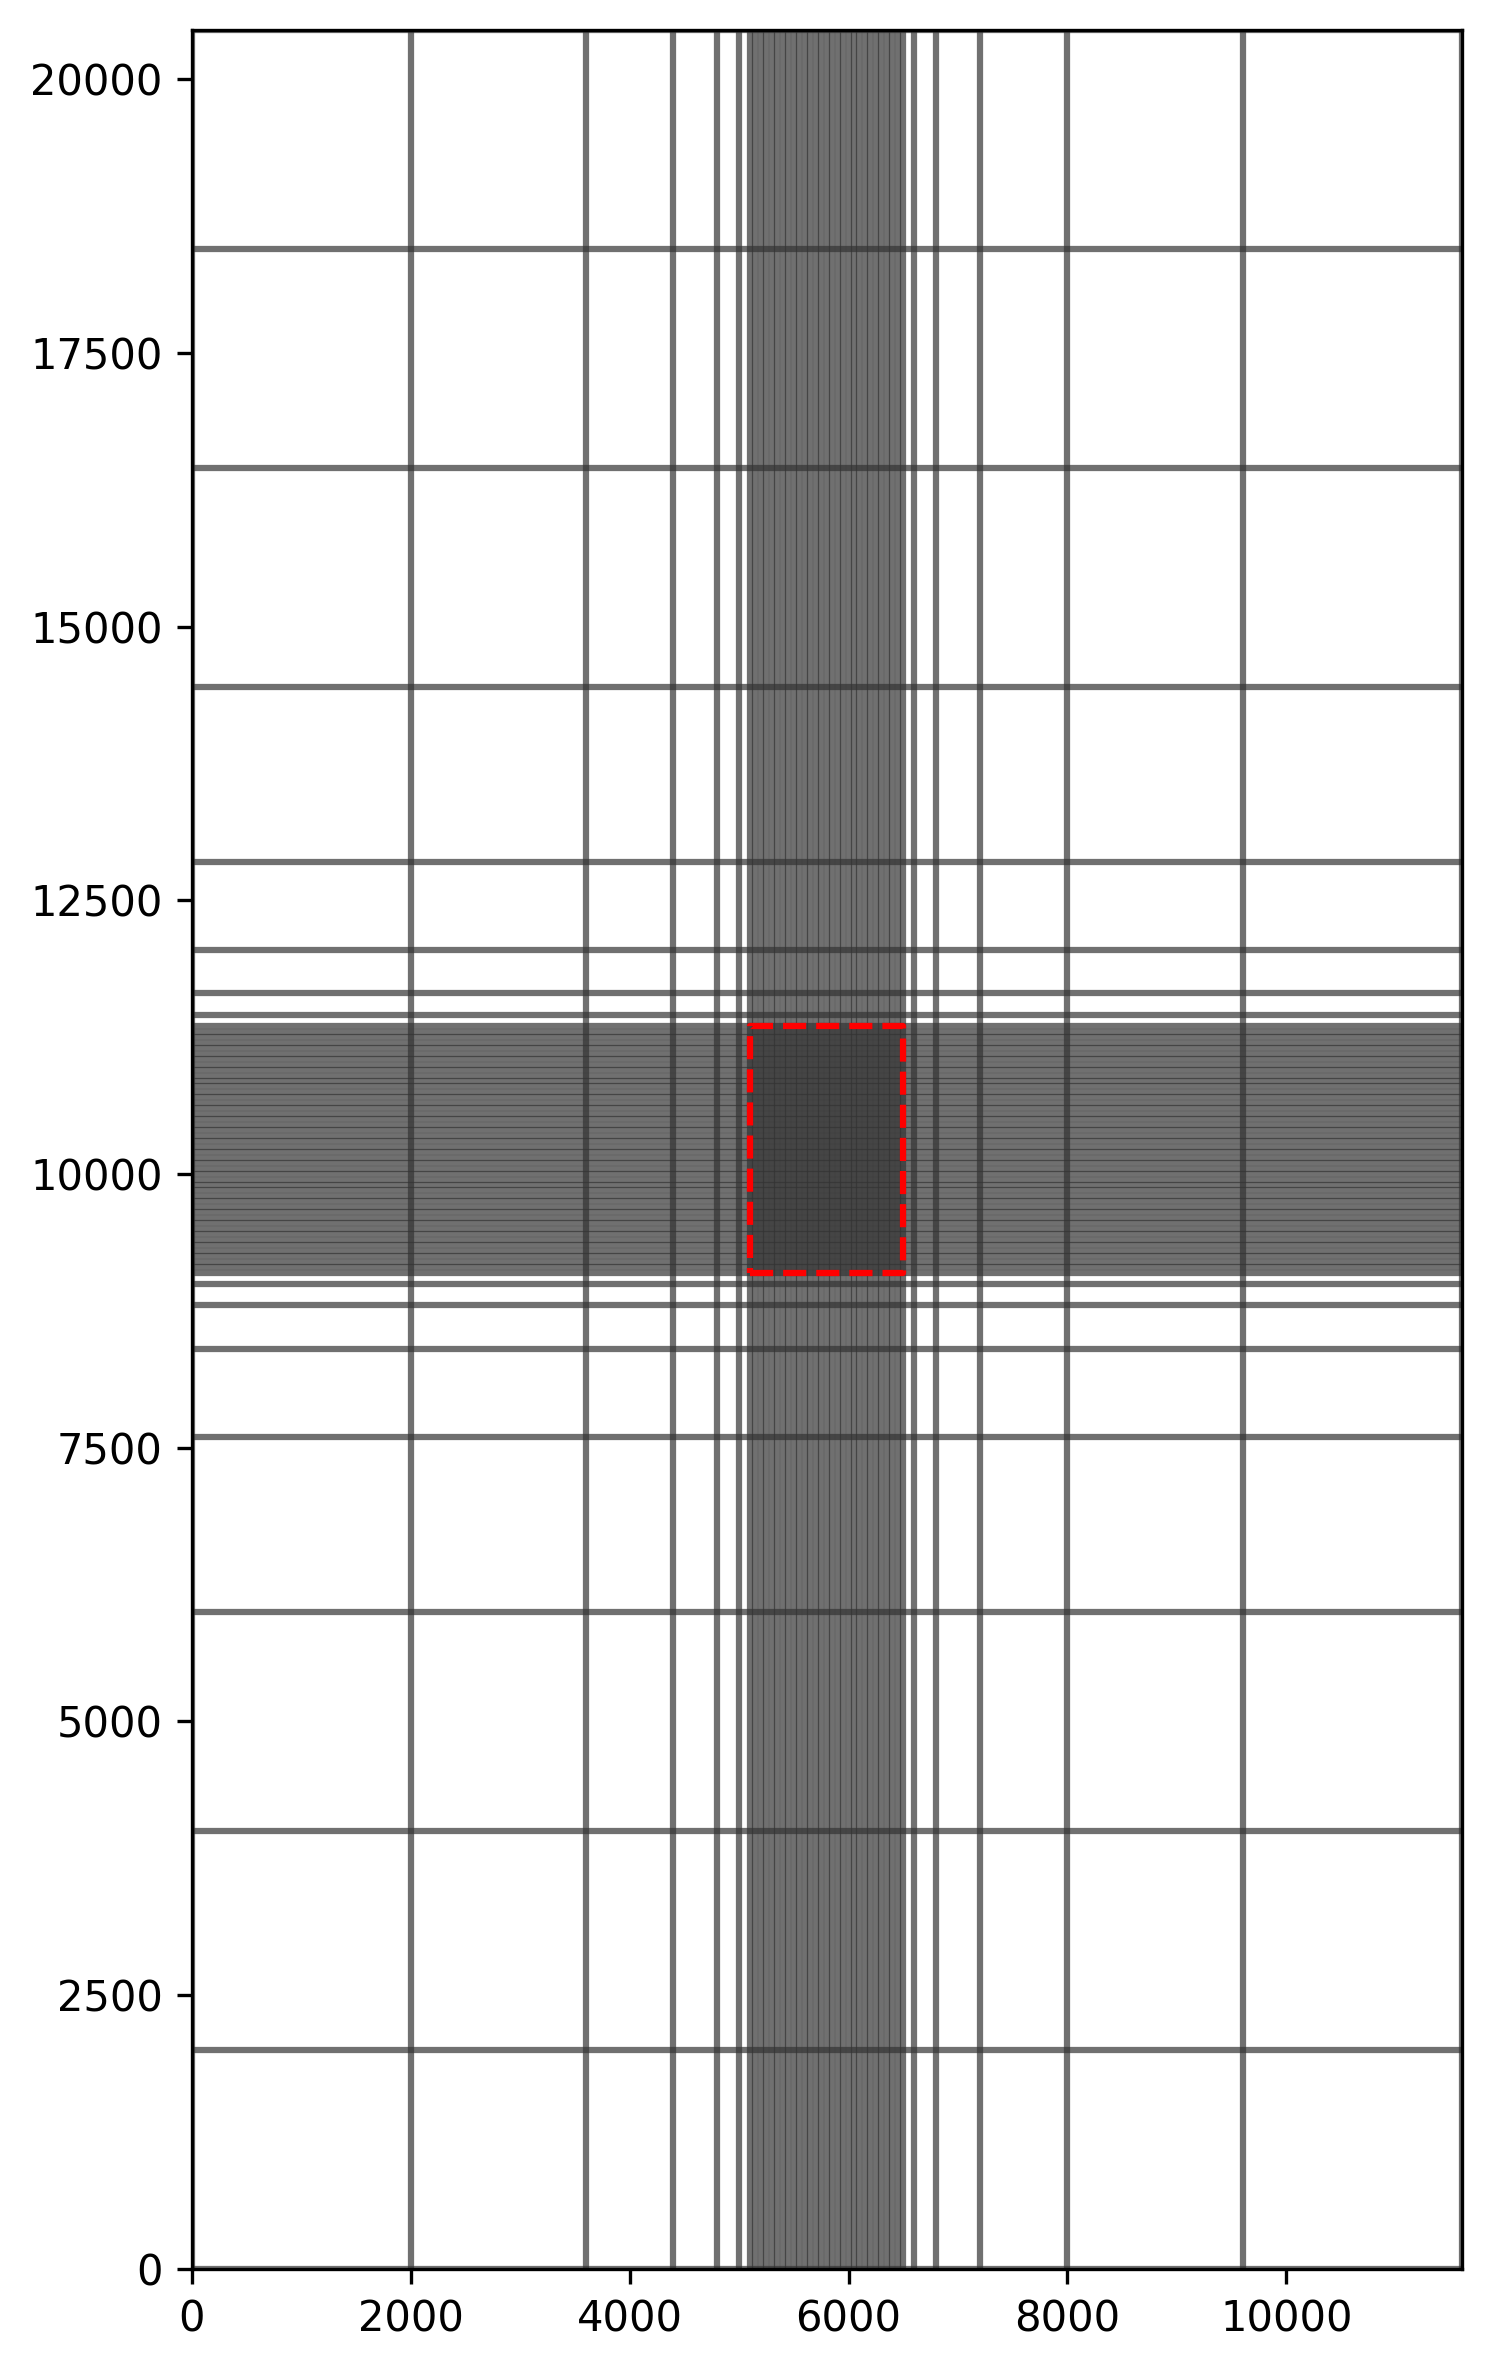

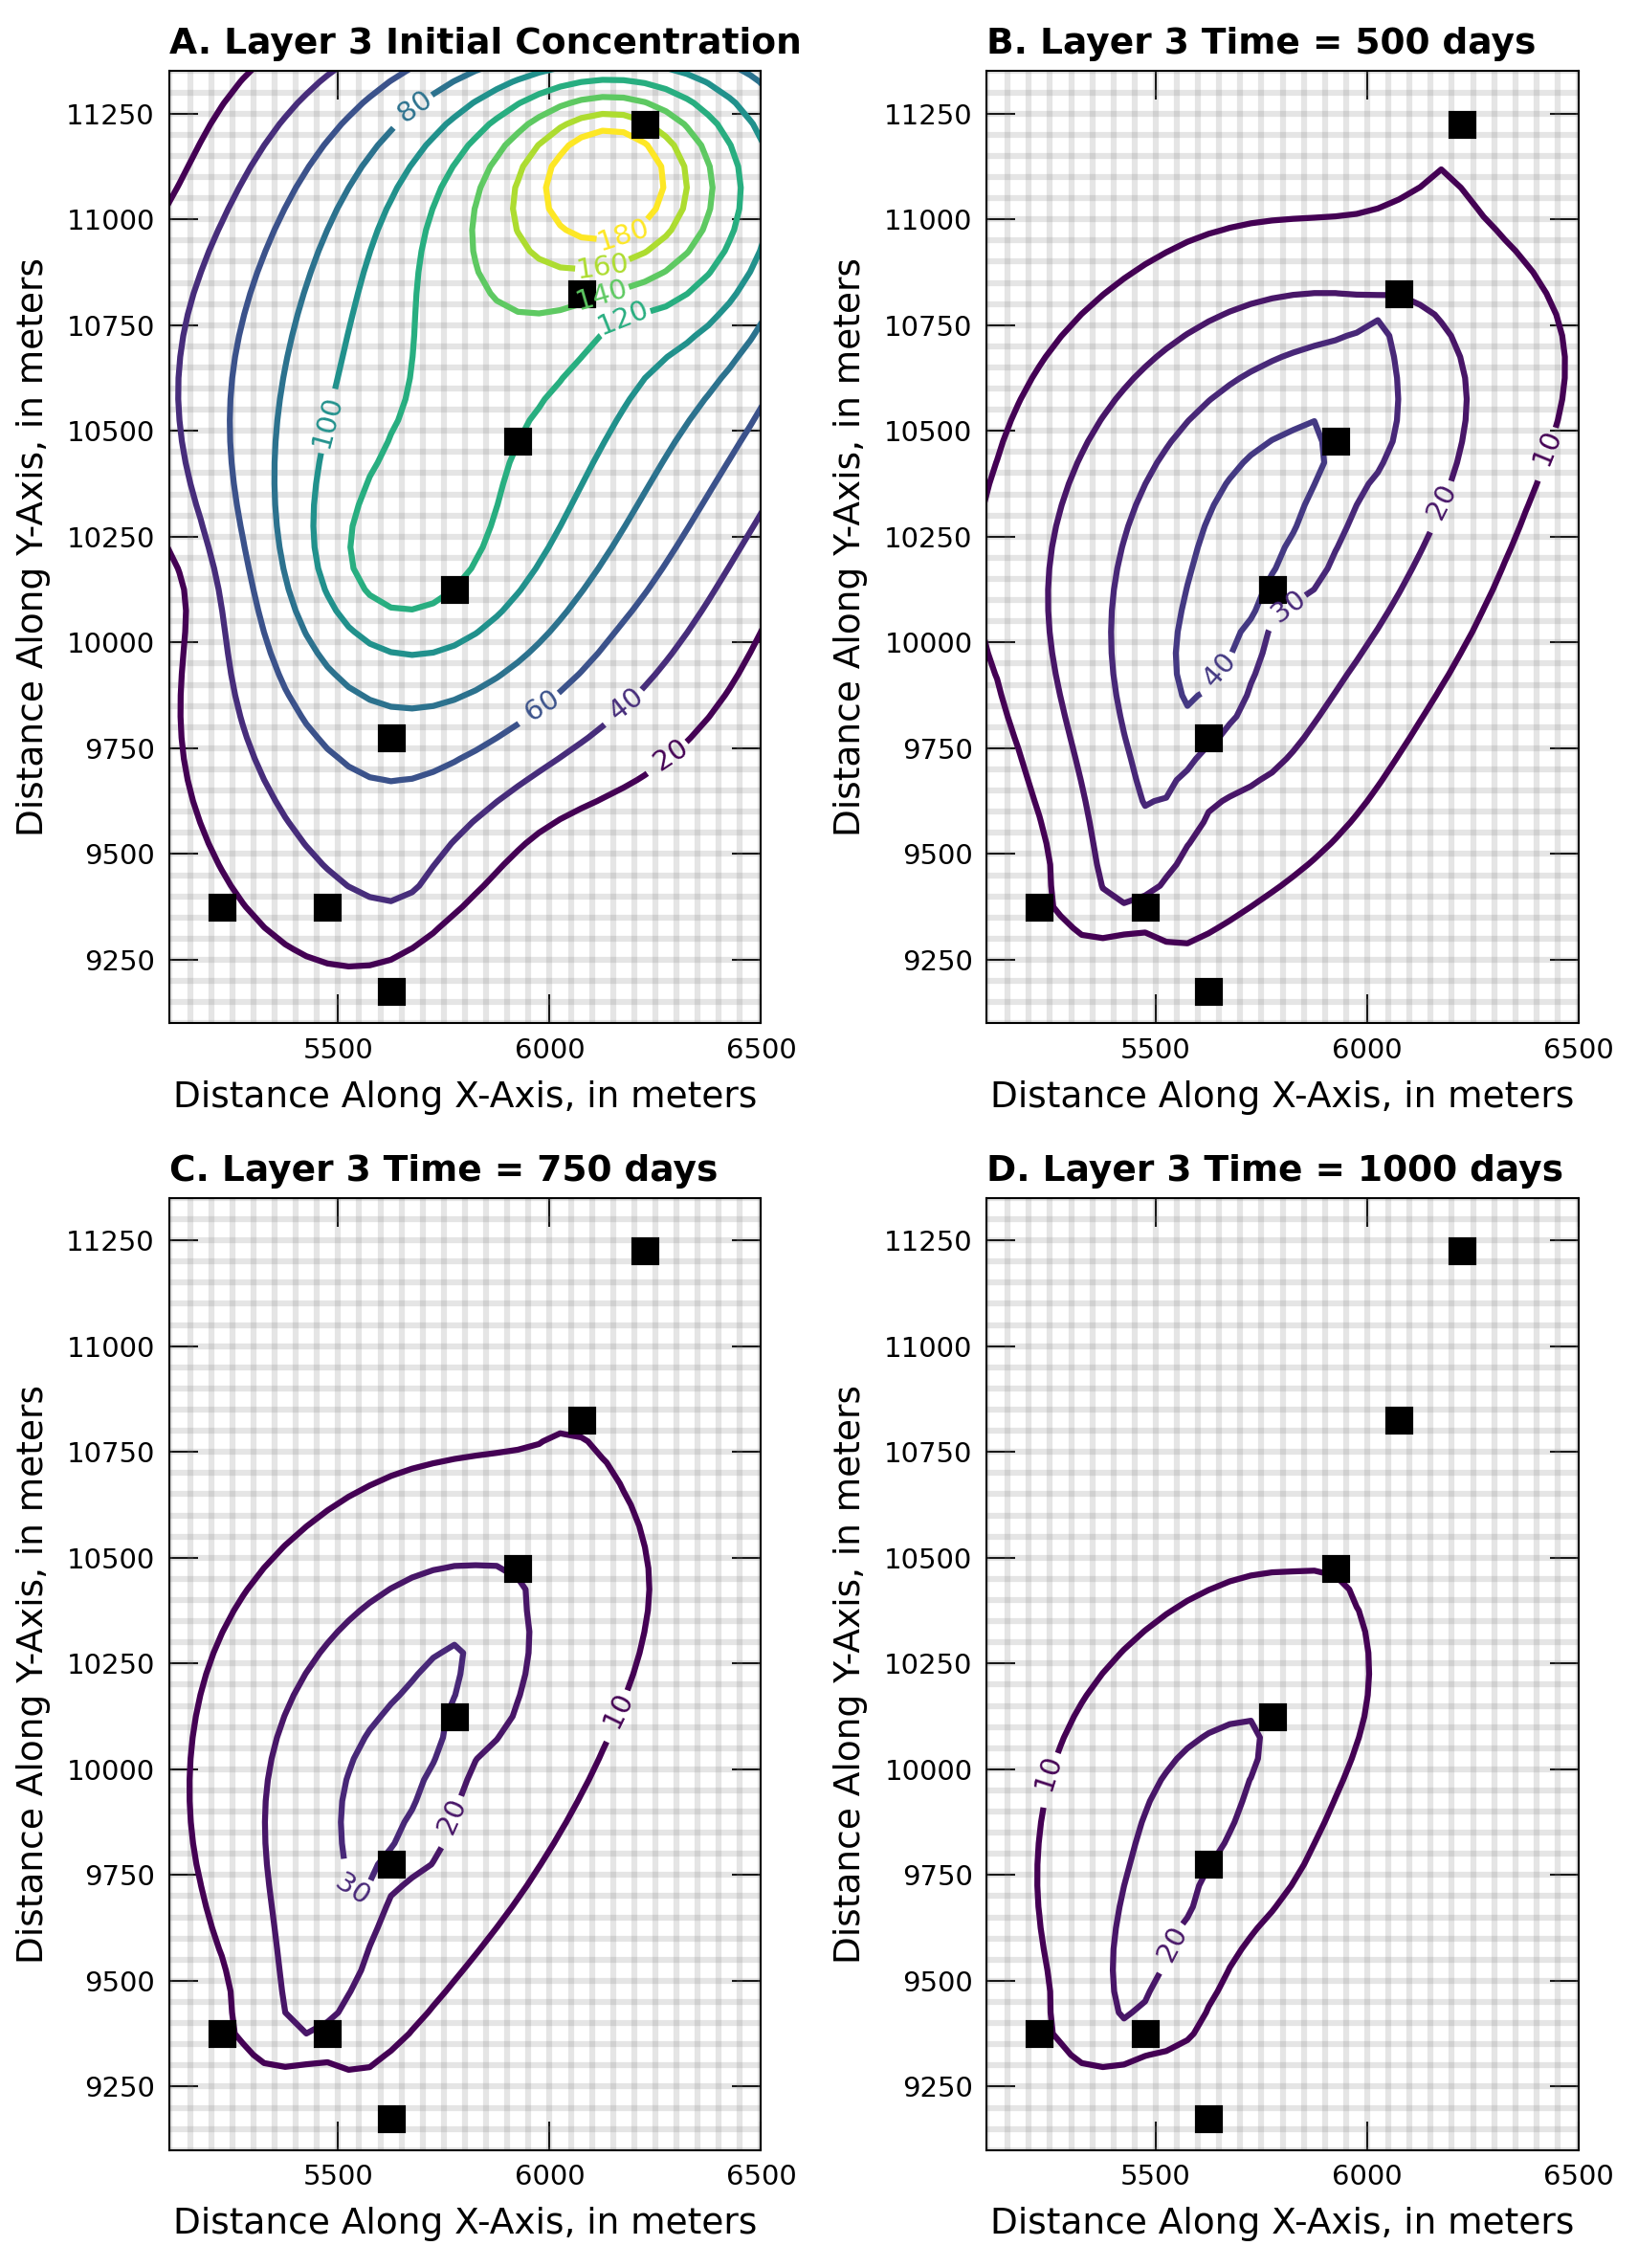

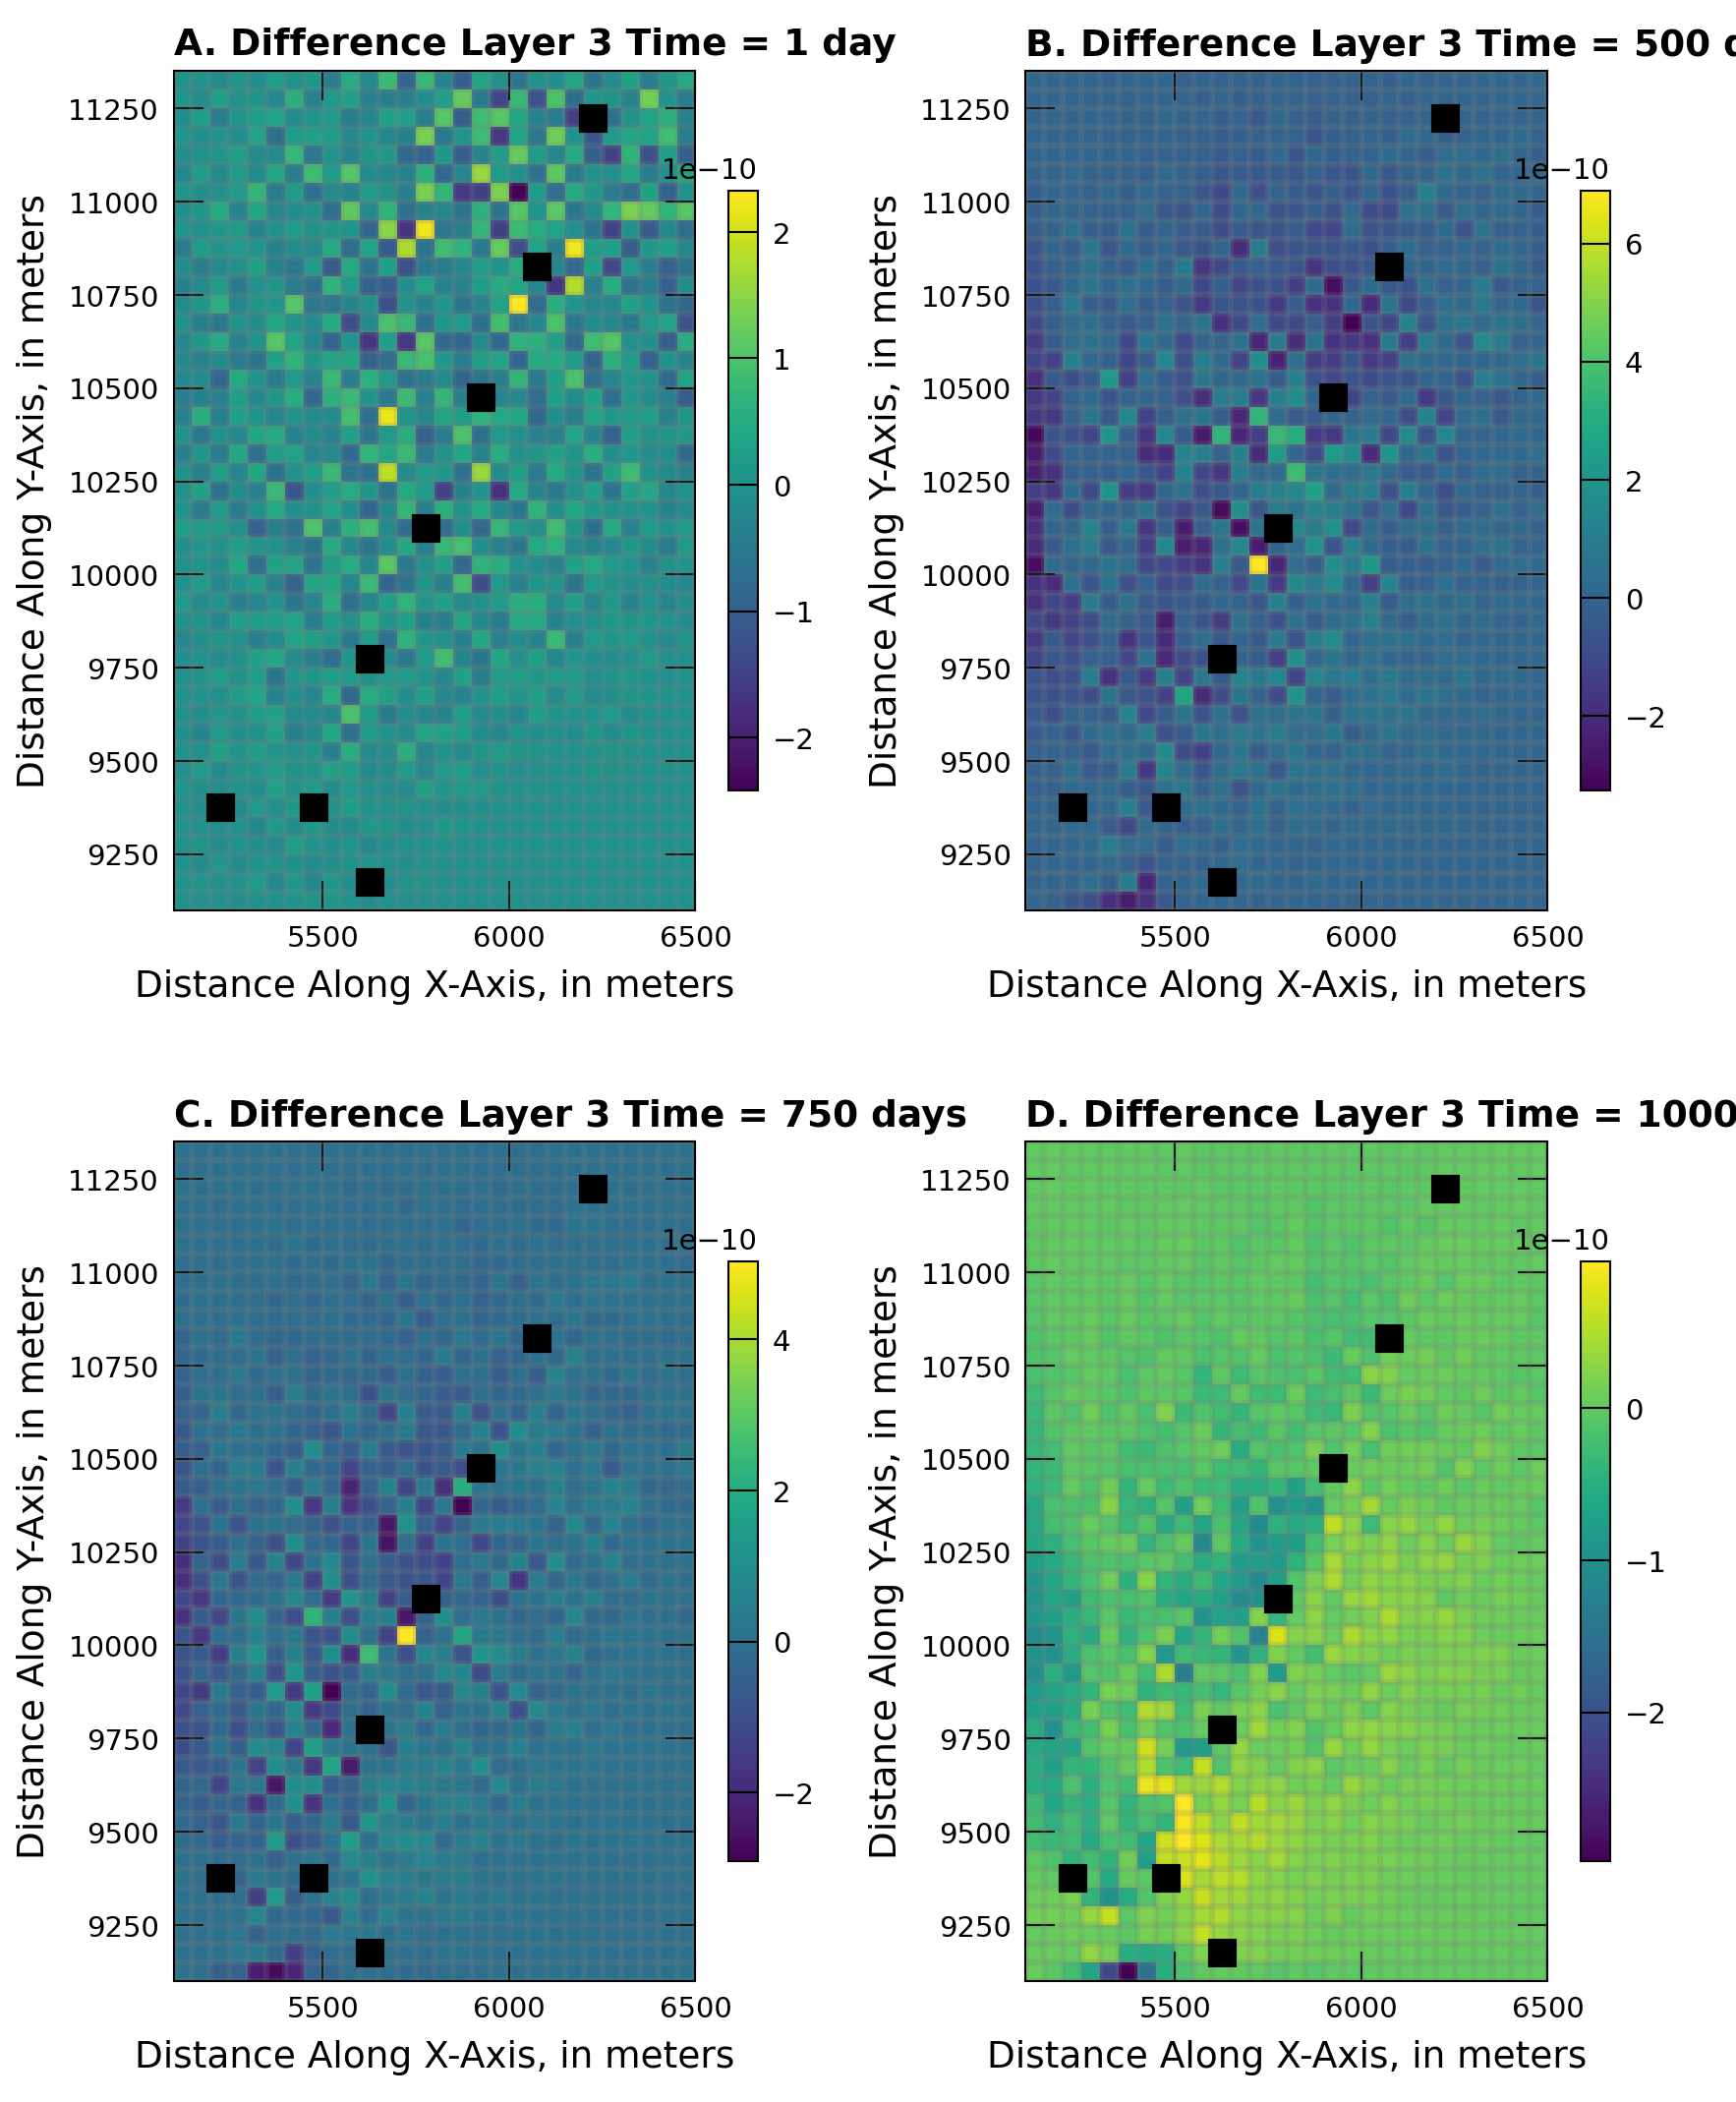

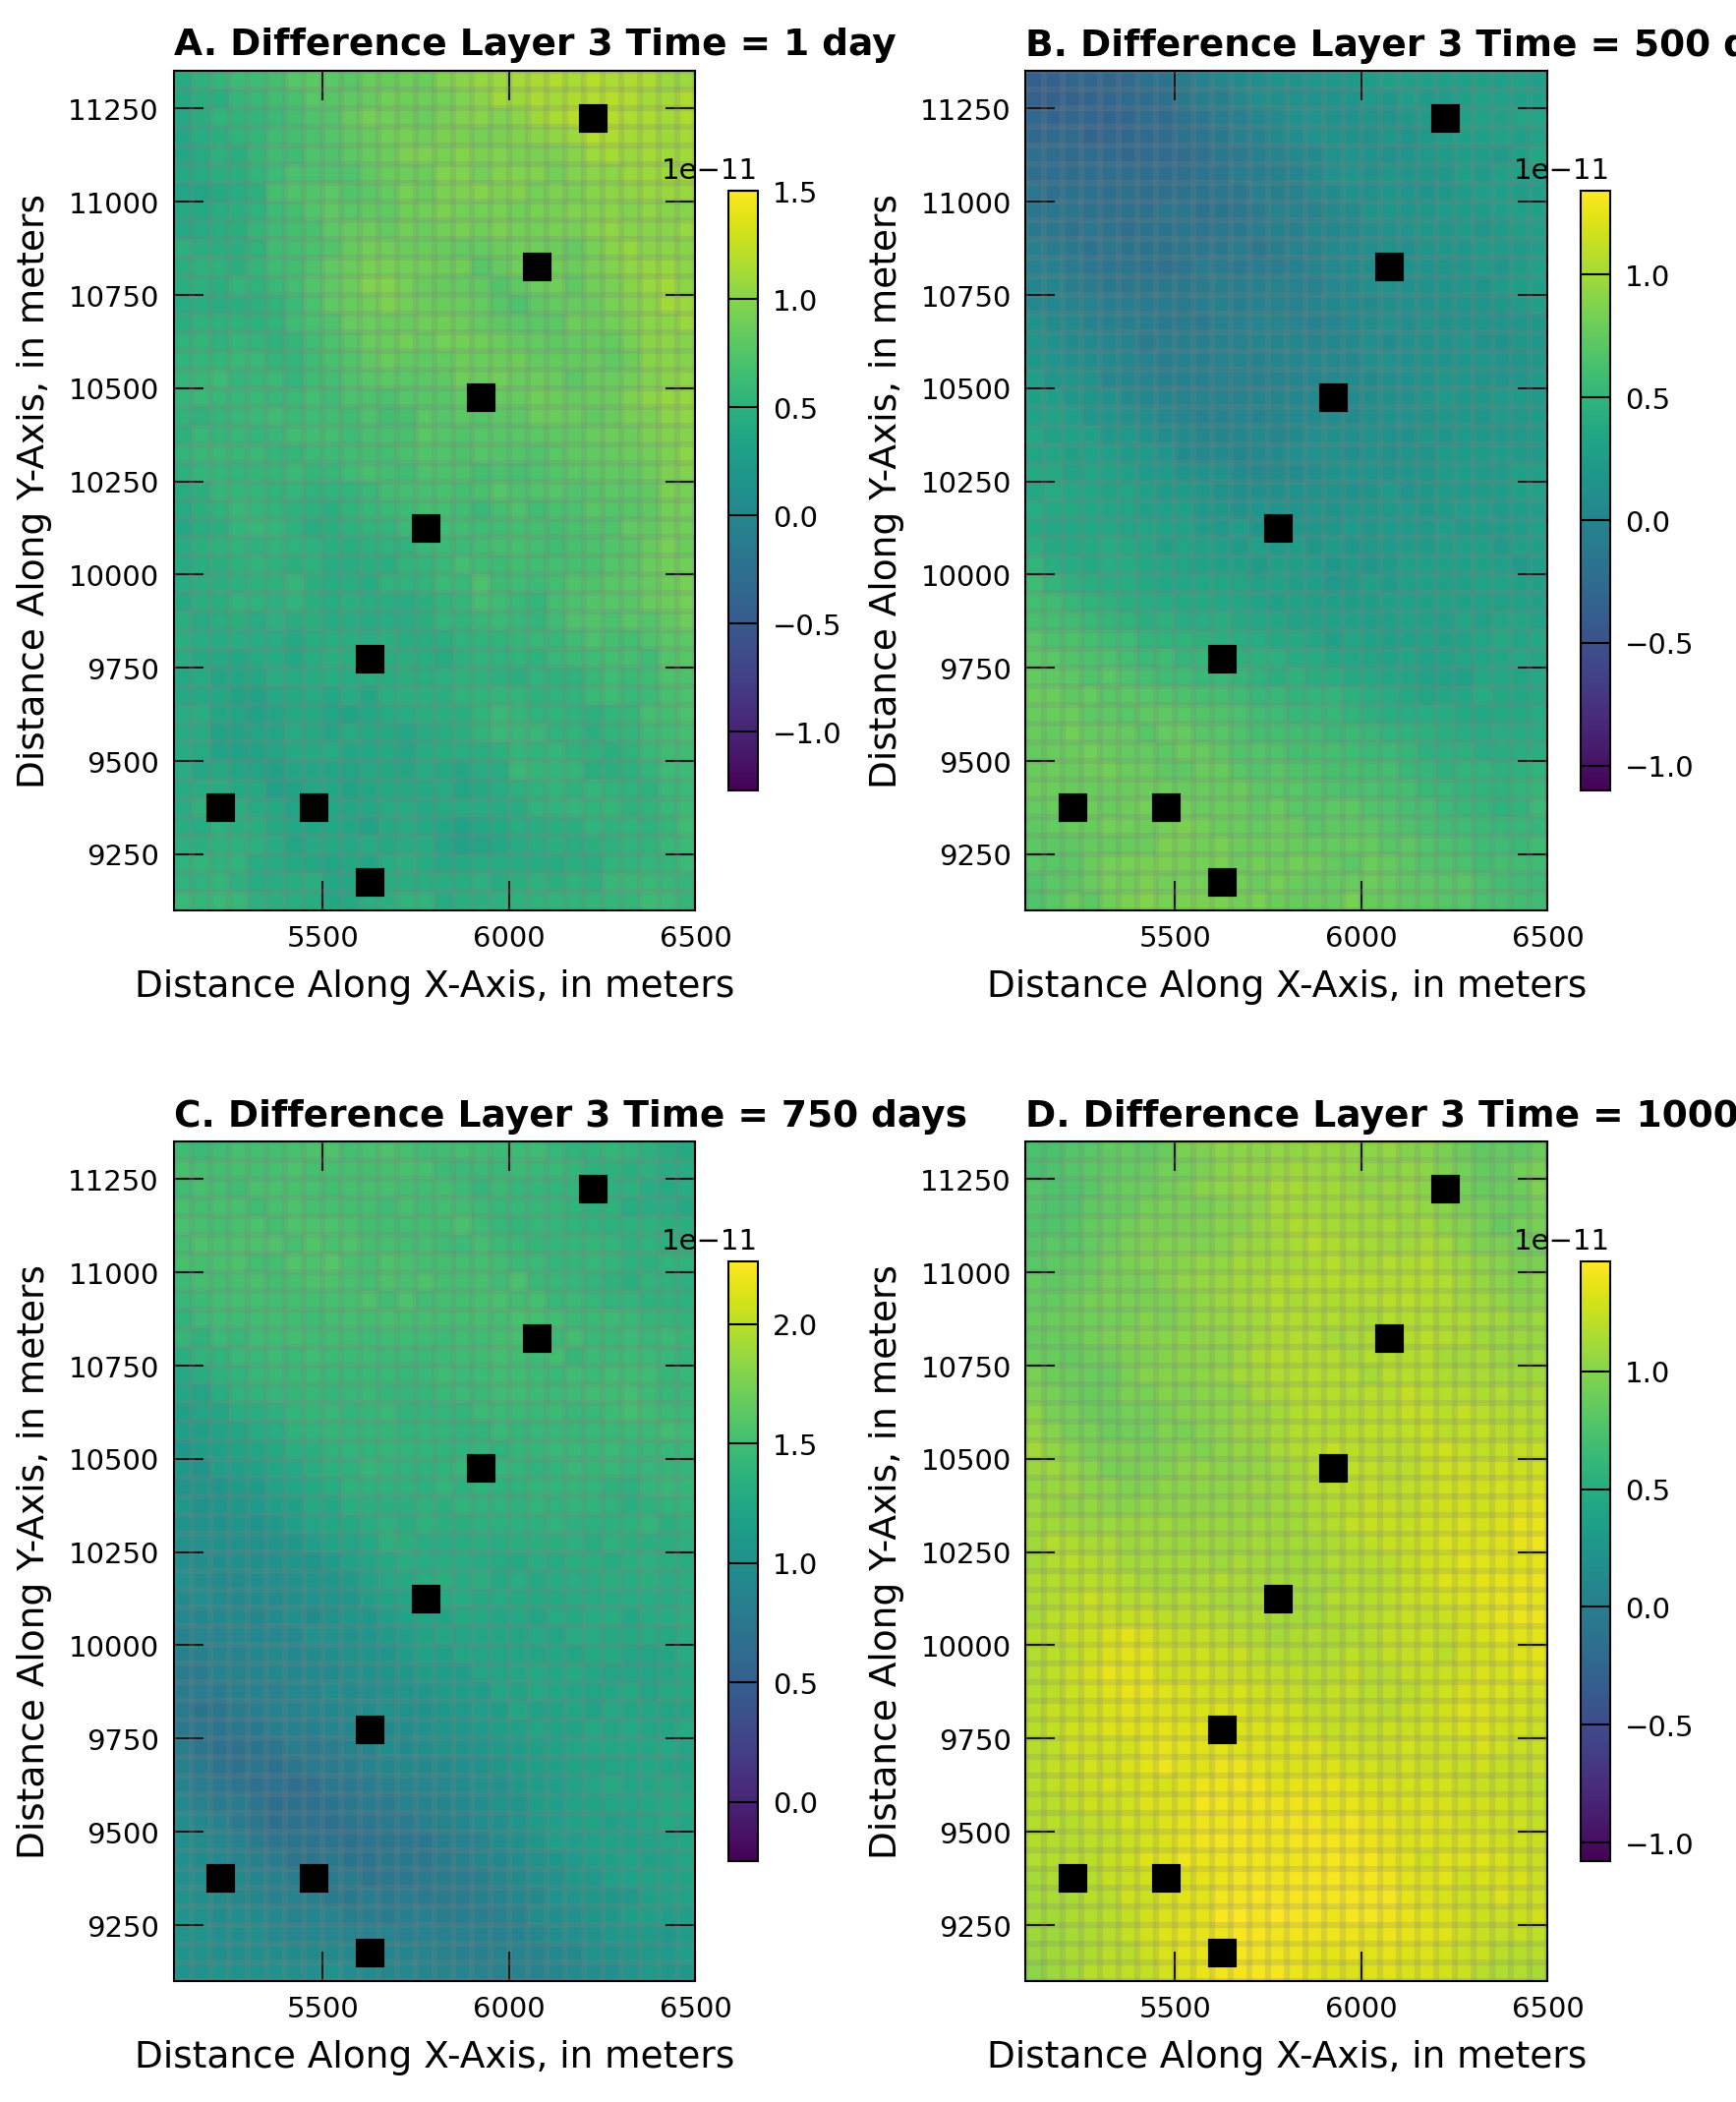

In [5]:
def scenario():
    sim = build_models()
    if write:
        sim.write_simulation()
    if run:
        run_models(sim)
    if plot:
        plot_results(sim)


scenario()